Nama     : Najwar Putra Kusumah Wardana

Dataset  : https://www.kaggle.com/datasets/abhikjha/movielens-100k

# Proyek Overview





Dalam era digital saat ini, industri hiburan mengalami lonjakan konten yang luar biasa cepat. Salah satu bentuk konten yang paling digemari masyarakat adalah film. Platform streaming seperti Netflix, Disney+, dan Amazon Prime menyuguhkan ribuan judul film dari berbagai genre setiap harinya. Namun, kelimpahan pilihan ini justru sering membuat pengguna kebingungan dalam menentukan film apa yang layak ditonton selanjutnya.

Di sinilah sistem rekomendasi berperan penting. Dengan memberikan saran film yang relevan dan sesuai dengan preferensi pengguna, sistem ini dapat meningkatkan pengalaman pengguna, menghemat waktu, dan mendorong eksplorasi konten baru. Salah satu pendekatan umum yang digunakan adalah Content-Based Filtering, yaitu merekomendasikan film berdasarkan kesamaan karakteristik konten seperti genre, sinopsis, atau kata kunci.

Pada proyek ini, akan dibangun sebuah sistem rekomendasi film sederhana berbasis konten menggunakan dataset MovieLens 100K, yang merupakan dataset populer dalam riset sistem rekomendasi. Dataset ini menyediakan informasi mengenai ribuan film beserta metadata-nya seperti genre, serta interaksi rating dari pengguna. Dengan pendekatan ini, sistem rekomendasi akan mampu menyarankan film-film yang memiliki kemiripan dengan film yang disukai oleh pengguna sebelumnya.

# Business Understanding

## Problem Statements


## Problem Statements

1. Pengguna sering merasa kebingungan dalam memilih film dari ribuan pilihan yang tersedia.
2. Banyak pengguna kehilangan ketertarikan terhadap platform karena rekomendasi film yang ditampilkan kurang relevan dengan preferensi mereka.
3. Tidak semua pengguna memberikan rating atau review, sehingga dibutuhkan metode yang dapat bekerja meskipun data pengguna terbatas.

## Goals

1. Membantu pengguna menemukan film yang relevan dengan preferensi mereka secara otomatis.
2. Meningkatkan keterlibatan pengguna dengan sistem melalui rekomendasi yang lebih personal.
3. Membangun sistem yang tetap dapat memberikan rekomendasi meskipun tanpa data interaksi pengguna (misalnya rating), dengan hanya memanfaatkan informasi dari film itu sendiri.

## Solution Approach

1. Menerapkan Content-Based Filtering, yaitu merekomendasikan film berdasarkan kesamaan konten (genre).
2. Menggunakan teknik TF-IDF Vectorization untuk mengekstraksi representasi fitur dari genre film.
3. Menghitung kemiripan antar film dengan Cosine Similarity untuk menghasilkan daftar rekomendasi.
4. Mengevaluasi hasil rekomendasi dengan metode manual dan contoh nyata (studi kasus pengguna yang menyukai satu film, sistem menyarankan film-film serupa).

# Data Understanding

## Mengimport Library

mengimport library yang diperlukan

In [3]:
import os
import re
import shutil
import zipfile
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report

## Data Loading

In [4]:
df = pd.read_csv(os.path.join('data_movies/movies.csv'))
print(df.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


##### 📌 Penjelasan Kode:
- pd.read_csv(...) digunakan untuk membaca file CSV ke dalam DataFrame.
- os.path.join(...) memastikan path yang digunakan fleksibel dan kompatibel di berbagai sistem operasi.
- print(df.head()) menampilkan 5 baris pertama dari dataset.
---

##### 📌 Deskripsi Kolom:
- movieId : ID unik untuk setiap film.
- title : Nama film beserta tahun rilisnya.
- genres : Genre film yang dipisahkan dengan tanda | (pipe).

## Penggabungan dengan ratings.csv

In [5]:
ratings_df = pd.read_csv(os.path.join('data_movies/ratings.csv'))

df_merged = pd.merge(ratings_df, df, on='movieId')
df_merged.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


#### 🧾 Penjelasan Kolom dalam Data Gabungan (df_merged)
Setelah kita gabungkan data ratings.csv dan movies.csv, kita punya beberapa kolom penting, yaitu:
| Kolom         | Penjelasan                                                                                                                                           |                                           |            |
| ------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------- | ---------- |
| **userId**    | ID pengguna yang memberikan rating. Tiap user punya ID unik, misalnya `1`, `2`, dst.                                                                 |                                           |            |
| **movieId**   | ID film yang dirujuk oleh pengguna. Ini juga jadi kunci untuk menghubungkan data antar tabel.                                                        |                                           |            |
| **rating**    | Nilai rating yang diberikan pengguna ke film, biasanya dalam skala 0.5 – 5.0.                                                                        |                                           |            |
| **timestamp** | Waktu saat rating diberikan, dalam format Unix timestamp (jumlah detik sejak 1 Januari 1970). Bisa dikonversi jadi tanggal kalau mau analisis waktu. |                                           |            |
| **title**     | Judul lengkap dari film, biasanya disertai dengan tahun rilis, misalnya `Toy Story (1995)`.                                                          |                                           |            |
| **genres**    | Genre dari film tersebut, bisa terdiri dari satu atau lebih genre, misalnya `Comedy`, `Action                                                        Thriller`, dll. Dipisahkan dengan tanda (pipe). |

---

#### 🚨 Ini Penting!
Dengan kolom-kolom ini, kita bisa melakukan berbagai analisis menarik, misalnya:
- Film paling sering diberi rating tinggi.
- Genre favorit user tertentu.
- Perubahan selera user dari waktu ke waktu (kalau kita ubah timestamp ke format tanggal).
- Rekomendasi film berdasarkan genre atau rating tertinggi.

### Deskripsi Variabel

#### menampilkan Type Variabel

In [6]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


#### 📌 Penjelasan:
- <class 'pandas.core.frame.DataFrame'>: Menunjukkan bahwa objek ini adalah sebuah DataFrame dari pustaka pandas.
- RangeIndex: Menandakan jumlah total baris adalah 100.836, dengan indeks mulai dari 0 sampai 100.835.
- Kolom-kolom dan Tipe Datanya:

| Kolom       | Non-Null Count | Tipe Data | Penjelasan                                                                        |     |
| ----------- | -------------- | --------- | --------------------------------------------------------------------------------- | --- |
| `userId`    | 100836         | `int64`   | ID pengguna. Semua baris memiliki nilai, tidak ada missing data.                  |     |
| `movieId`   | 100836         | `int64`   | ID film. Sama seperti `userId`, tidak ada nilai kosong.                           |     |
| `rating`    | 100836         | `float64` | Rating yang diberikan pengguna, berupa angka desimal.                             |     |
| `timestamp` | 100836         | `int64`   | Waktu saat rating diberikan dalam format Unix timestamp.                          |     |
| `title`     | 100836         | `object`  | Judul film (tipe data `object` berarti ini berupa teks/string).                   |     |
| `genres`    | 100836         | `object`  | Genre film, juga berupa teks yang berisi satu atau lebih genre dipisahkan oleh \` | \`. |

- dtypes: Merinci jenis tipe data yang digunakan: 1 kolom float64, 3 kolom int64, dan 2 kolom object.
- memory usage: Menunjukkan jumlah memori yang digunakan oleh DataFrame ini di RAM, yaitu sekitar 4,6 megabyte.

In [7]:
total_row, total_column = df_merged.shape
print(f"Total of rows: {total_row}")
print(f"Total of column: {total_column}")

Total of rows: 100836
Total of column: 6


#### 🔢 Jumlah Baris dan Kolom
1. Total Baris (Rows): 100.836
   - Artinya, dataset ini memiliki 100.836 entri atau data rating individual yang diberikan oleh berbagai pengguna terhadap berbagai film.
2. Total Kolom (Columns): 6
   - Dataset ini terdiri dari 6 kolom, yaitu:
       - userId – ID pengguna yang memberikan rating
       - movieId – ID film yang diberi rating
       - rating – Nilai rating yang diberikan
       - timestamp – Waktu saat rating diberikan (dalam Unix time)
       - title – Judul film
       - genres – Genre film
---
#### 🧠 Kesimpulan:
- Dataset ini cukup besar dan lengkap, cocok untuk dilakukan eksplorasi data seperti:
- Mengetahui genre yang paling sering ditonton
- Film dengan rating tertinggi
- Aktivitas pengguna berdasarkan waktu

#### Statistik Deskripsi dari Data

In [8]:
df_merged.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


#### 📊 Statistik Deskriptif
Fungsi describe() memberikan ringkasan statistik untuk kolom numerik dalam dataset. Berikut penjelasannya untuk masing-masing kolom:

| Kolom         | Penjelasan Singkat                                                                                                                                                               |
| ------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **userId**    | ID unik pengguna. Total pengguna adalah 610 (dari min=1 hingga max=610), dengan nilai rata-rata 326.                                                                             |
| **movieId**   | ID film. Film memiliki ID dari 1 hingga 193609, meskipun jumlah film unik biasanya lebih kecil karena ada ID yang tidak terpakai.                                                |
| **rating**    | Rating yang diberikan oleh pengguna, mulai dari **0.5 (min)** hingga **5.0 (max)**, dengan rata-rata sekitar **3.50**. Ini menunjukkan kebanyakan rating berada di tengah (3-4). |
| **timestamp** | Waktu saat rating diberikan, dalam format Unix timestamp (jumlah detik sejak 1 Januari 1970). Perlu dikonversi ke format tanggal agar lebih mudah dibaca.                        |

---
#### 📚 Rangkuman Statistik:

| Statistik    | userId  | movieId | rating  | timestamp (Unix)                   |
| ------------ | ------- | ------- | ------- | ---------------------------------- |
| **count**    | 100,836 | 100,836 | 100,836 | 100,836                            |
| **mean**     | 326.13  | 19,435  | 3.50    | 1.205.946.000                      |
| **std**      | 182.62  | 35,531  | 1.04    | 216.261.000                        |
| **min**      | 1       | 1       | 0.5     | 828.124.600 (sekitar tahun 1996)   |
| **25% (Q1)** | 177     | 1,199   | 3.0     | 1.019.124.000                      |
| **50% (Q2)** | 325     | 2,991   | 3.5     | 1.186.087.000                      |
| **75% (Q3)** | 477     | 8,122   | 4.0     | 1.435.994.000                      |
| **max**      | 610     | 193,609 | 5.0     | 1.537.799.000 (sekitar tahun 2018) |

#### 🎯 Insight dari Data Understanding
1. Volume dan Kelengkapan Data
- Dataset terdiri dari 100.836 baris dan 6 kolom, dengan tidak ada missing value — artinya data bersih dan siap dianalisis.
- Kolom-kolomnya menggabungkan informasi penting:
    - siapa yang menonton
    - film apa yang ditonton
    - rating-nya, kapan menontonnya
    - serta genre film.

2. Distribusi Rating
- Rata-rata rating yang diberikan pengguna adalah 3.50 (dari skala 0.5 sampai 5).
- Mayoritas rating berada di rentang 3.0 – 4.0, menunjukkan kecenderungan pengguna memberi nilai yang cukup positif, tapi tidak ekstrem.

3. Pengguna dan Film
- Memiliki 610 pengguna unik (userId dari 1 hingga 610).
- Kolom `movieId` berkisar dari 1 hingga 193.609, namun angka ini tidak menunjukkan jumlah film sebenarnya karena banyak ID tidak terpakai.

4. Genre Film
Setiap film bisa memiliki satu atau lebih genre, yang memungkinkan kita melakukan analisis genre populer, genre dengan rating tertinggi, dll.

5. Waktu Pemberian Rating
Kolom timestamp menunjukkan data mencakup periode panjang (sekitar 1996–2018), sehingga memungkinkan analisis tren rating dari waktu ke waktu (misalnya: apakah pengguna makin kritis seiring waktu?).

---
#### 💡 Kesimpulan
- Dataset ini cukup lengkap dan bersih untuk langsung dilakukan exploratory data analysis (EDA) dan modeling seperti sistem rekomendasi.
- Kita bisa melanjutkan ke analisis lebih dalam seperti:
    - Film atau genre dengan rating tertinggi.
    - Perilaku user tertentu dalam memberi rating.
    - Pola rating berdasarkan tahun/genre.

### Data Cleaning

#### Data Duplikasi

In [9]:
df_merged[df_merged.duplicated]

,userId,movieId,rating,timestamp,title,genres


tidak ada data yang duplikasi

#### Missing Value

In [10]:
pd.DataFrame({'Nilai yang Kosong':df_merged.isnull().sum()})

,Nilai yang Kosong
userId,0
movieId,0
rating,0
timestamp,0
title,0
genres,0


tidak ada data yang missing value

# Exploratory Data  Analysis (EDA)

## Memisahkan Genre dan Menghitung Frekuensi

In [11]:
df_merged['genres_split'] = df_merged['genres'].str.split('|')

genres_exploded = df_merged.explode('genres_split')

#### 🧩 Penjelasan Kode:
1. `df_merged['genres_split'] = df_merged['genres'].str.split('|'): `
Membagi kolom genres menjadi list genre, karena beberapa film memiliki lebih dari satu genre.

2. `genres_exploded = df_merged.explode('genres_split'): `
Menggunakan explode() untuk membuat setiap genre menjadi baris tersendiri, sehingga satu film dengan 3 genre akan muncul 3 kali (satu per genre).


## Grafik Distribusi Jumlah Film per Genre

/var/folders/mf/d68wp8695t52xvrgzxzcwlb40000gn/T/ipykernel_14472/782668640.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


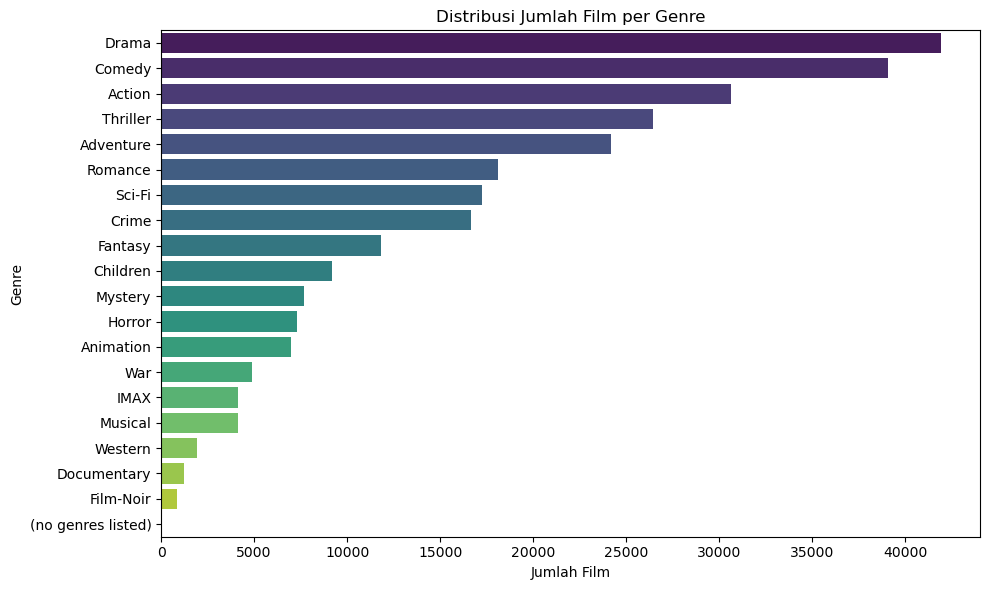

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=genres_exploded,
    y='genres_split',
    order=genres_exploded['genres_split'].value_counts().index,
    palette='viridis'
)

plt.title('Distribusi Jumlah Film per Genre')
plt.xlabel('Jumlah Film')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()


#### 🧩 Penjelasan Kode:
`sns.countplot(..., y='genres_split', order=..., palette='viridis'): `
- Menggunakan countplot untuk menghitung dan memvisualisasikan jumlah film per genre.
- Parameter order digunakan agar genre ditampilkan dari jumlah terbanyak ke paling sedikit.
- Palet viridis memberikan warna gradasi yang menarik.

#### 📌 Insight dari Grafik:
1. Genre paling umum dalam dataset adalah:
   - Drama: Lebih dari 40.000 film.
   - Comedy: Berada pada ujung akhir frekuensi 35.000 film, sekitar 37.000 - 39.000 film.
   - Action: Berada pada awal frekuensi 30.000 film, sekitar 30.000 - 33.000 film. 
   - Thriller: Berada pada awal frekuensi 25.000 film, sekitar 25.000 - 27.000 film.
   - Adventure: Berada pada ujung frekuensi 20.000 film, sekitar 23.000 - 24.000 film.

2. Genre dengan jumlah film paling sedikit:
   - Film-Noir, Documentary, dan (no genres listed) adalah genre dengan jumlah film paling sedikit.
   - (no genres listed) artinya ada film yang tidak memiliki informasi genre.

#### 💡 Kesimpulan:
- Sebagian besar film dalam dataset ini bergenre Drama dan Comedy, menunjukkan bahwa kedua genre ini paling populer atau paling banyak diproduksi.
- Genre seperti War, IMAX, dan Film-Noir tergolong niche (khusus), sehingga cocok jika ingin eksplorasi selera pengguna unik.
- Visualisasi ini sangat berguna untuk analisis preferensi genre, baik secara umum maupun per user nanti.

## Distribusi Panjang Judul Film

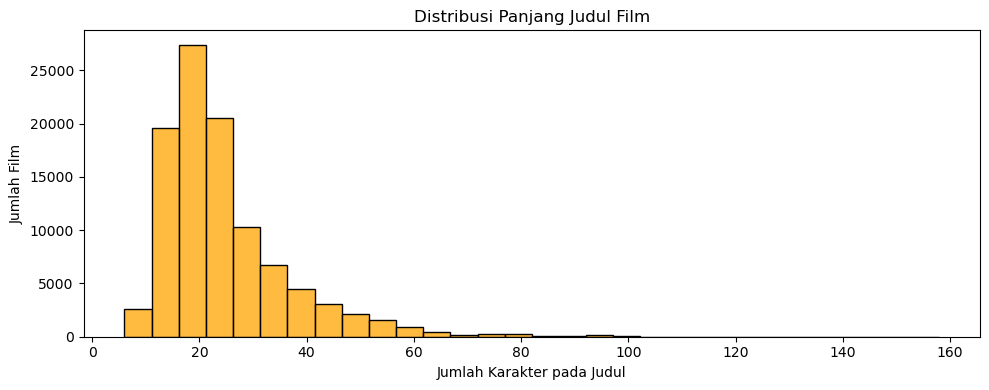

In [13]:
df_merged['title_length'] = df_merged['title'].str.len()

plt.figure(figsize=(10, 4))
sns.histplot(df_merged['title_length'], bins=30, color='orange')
plt.title('Distribusi Panjang Judul Film')
plt.xlabel('Jumlah Karakter pada Judul')
plt.ylabel('Jumlah Film')
plt.tight_layout()
plt.show()


#### 📌 Insight dari Grafik:
- Sebagian besar judul film memiliki panjang antara 15 hingga 30 karakter.
- Distribusi bersifat right-skewed (miring ke kanan), artinya:
  - Mayoritas judul film pendek atau sedang.
  - Hanya sedikit judul film yang sangat panjang (di atas 60 karakter).

---
#### 💡 Kesimpulan:
- Judul film dalam dataset umumnya ringkas, yang kemungkinan mencerminkan praktik umum industri film agar judul mudah diingat.
- Panjang judul film bisa menjadi fitur menarik untuk analisis lebih lanjut, misalnya:
  - Apakah judul yang lebih panjang cenderung mendapat rating lebih rendah/tinggi?
  - Apakah genre tertentu cenderung memiliki judul yang lebih panjang?


## Korelasi Antar Fitur Numerik

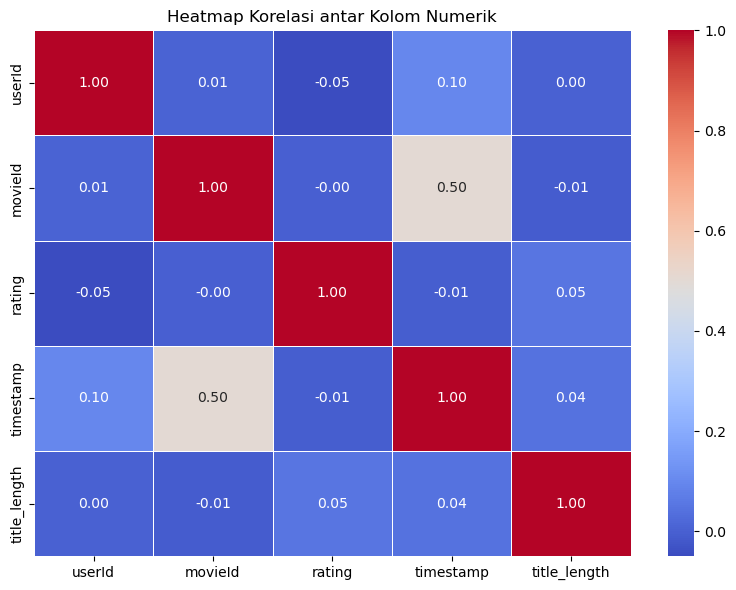

In [14]:
numeric_df = df_merged.select_dtypes(include=['int64', 'float64'])

corr = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi antar Kolom Numerik')
plt.tight_layout()
plt.show()


#### 🎯 Tujuan:
Heatmap ini menunjukkan hubungan linear (korelasi Pearson) antara kolom-kolom numerik dalam dataset gabungan df_merged.

---
#### 📌 Interpretasi Heatmap:
| Kolom                      | Korelasi yang Terlihat      | Penjelasan Singkat                                                                                  |
| -------------------------- | --------------------------- | --------------------------------------------------------------------------------------------------- |
| **userId & rating**        | -0.05 (lemah negatif)       | Tidak ada hubungan kuat antara user ID dan rating yang diberikan.                                   |
| **movieId & timestamp**    | **0.50 (moderat positif)**  | Film dengan ID lebih besar (film lebih baru) cenderung mendapatkan rating di waktu yang lebih baru. |
| **title\_length & rating** | 0.05 (sangat lemah positif) | Judul panjang tidak terlalu memengaruhi rating yang diberikan.                                      |
| **timestamp & rating**     | -0.01 (tidak signifikan)    | Waktu pemberian rating tidak terlalu memengaruhi besarnya rating.                                   |

---
💡 Kesimpulan:
- Korelasi antar kolom numerik dalam dataset ini cenderung lemah atau tidak signifikan secara statistik.
- Satu-satunya korelasi yang cukup mencolok adalah antara movieId dan timestamp (0.50), yang masuk akal karena film dengan ID lebih tinggi umumnya lebih baru, dan mendapat rating di waktu yang lebih modern.
- Korelasi rendah antara rating dengan kolom lain menunjukkan bahwa preferensi pengguna tidak mudah diprediksi hanya dengan fitur numerik sederhana ini.

## Avarage Rating and Number of Reviews per Genre

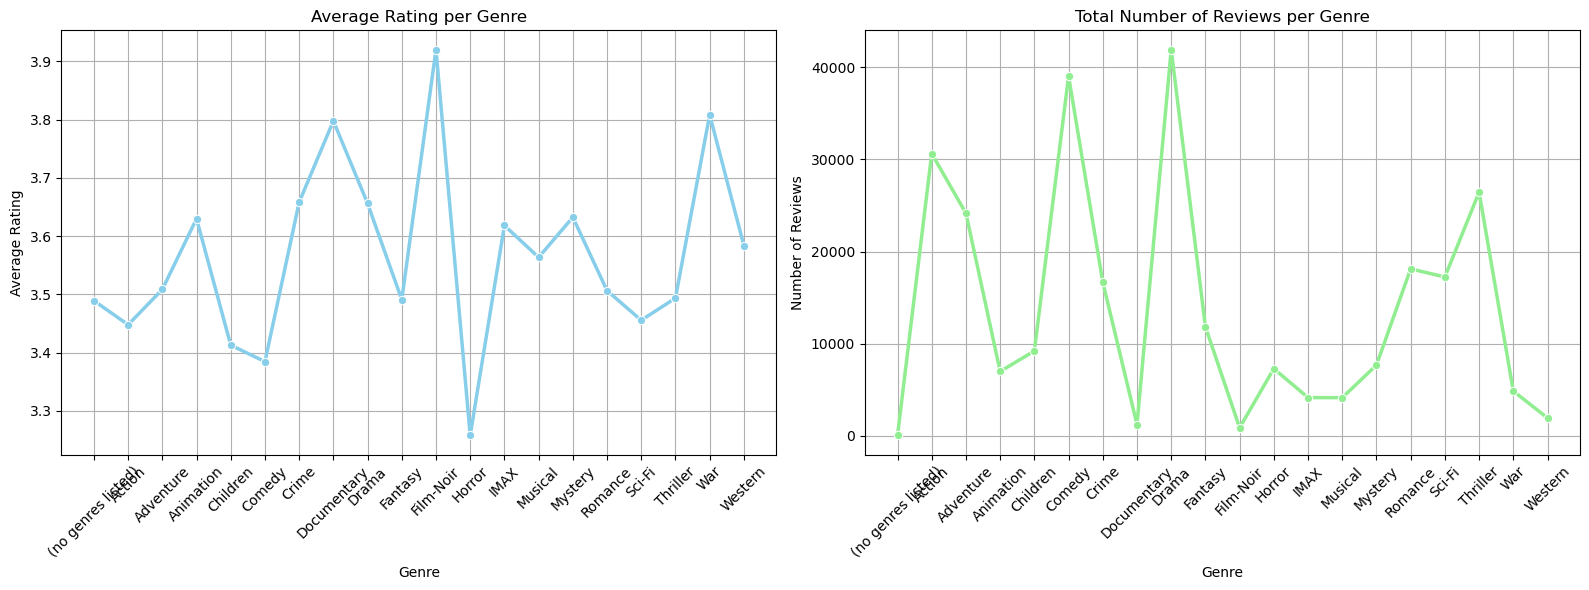

In [15]:
genre_df = df_merged.copy()

genre_df['genres'] = genre_df['genres'].str.split('|')
genre_df = genre_df.explode('genres')

genre_rating_avg = genre_df.groupby('genres')['rating'].mean().reset_index()

genre_rating_count = genre_df.groupby('genres')['rating'].count().reset_index()
genre_rating_count.columns = ['genres', 'Number_of_Reviews']

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

sns.lineplot(
    data=genre_rating_avg,
    x='genres',
    y='rating',
    marker='o',
    color='skyblue',
    linewidth=2.5,
    ax=axes[0]
)
axes[0].set_title('Average Rating per Genre')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Average Rating')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

sns.lineplot(
    data=genre_rating_count,
    x='genres',
    y='Number_of_Reviews',
    marker='o',
    color='lightgreen',
    linewidth=2.5,
    ax=axes[1]
)
axes[1].set_title('Total Number of Reviews per Genre')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Number of Reviews')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)

plt.tight_layout()
plt.show()


#### 🎬 Analisis Rating dan Jumlah Review berdasarkan Genre:
- Visualisasi ini menggambarkan dua hal penting dalam industri film berdasarkan genre:
    - Rata-rata rating per genre
    - Total jumlah review per genre
---
#### 📊 Grafik Kiri – Average Rating per Genre
- Menampilkan rata-rata rating film berdasarkan genre.
- Genre dengan rating tertinggi:
  - Film-Noir, Documentary, War → rata-rata rating mendekati atau di atas 3.8.
- Genre dengan rating terendah:
  - Horror, Comedy, Children → mendekati 3.3 - 3.4.

> 👉 Insight: Genre seperti Documentary dan Film-Noir mungkin memiliki audiens yang lebih khusus dan serius, sehingga memberi rating lebih tinggi.
---
#### 📈 Grafik Kanan – Total Number of Reviews per Genre
- Menampilkan jumlah total review yang diberikan per genre.
- Genre dengan jumlah review terbanyak:
  - Drama, Comedy, dan Action.
- Genre dengan jumlah review sangat sedikit:
  - IMAX, Film-Noir, Musical.

> 👉 Insight: Genre populer seperti Drama dan Comedy memang umum disukai, sedangkan genre Musical, Film-Noir, atau Western memiliki pangsa pasar yang lebih kecil.
---
#### 🎯 Kesimpulan:
| Genre          | Rata-rata Rating Tinggi | Jumlah Review Tinggi | Catatan                                       |
| -------------- | ----------------------- | -------------------- | --------------------------------------------- |
| Film-Noir      | ✅                       | ❌                    | Disukai secara kualitas, tapi jarang ditonton |
| Drama          | ✅                       | ✅                    | Populer dan dinilai baik                      |
| Horror         | ❌                       | ⚠️                   | Kurang disukai, tapi cukup sering ditonton    |
| Documentary    | ✅                       | ❌                    | Disukai oleh niche audiens                    |
| Comedy, Action | ⚠️                      | ✅                    | Populer, tapi rating relatif rendah           |

## Brand and Product Based on Rating

/var/folders/mf/d68wp8695t52xvrgzxzcwlb40000gn/T/ipykernel_14472/2112999982.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/mf/d68wp8695t52xvrgzxzcwlb40000gn/T/ipykernel_14472/2112999982.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


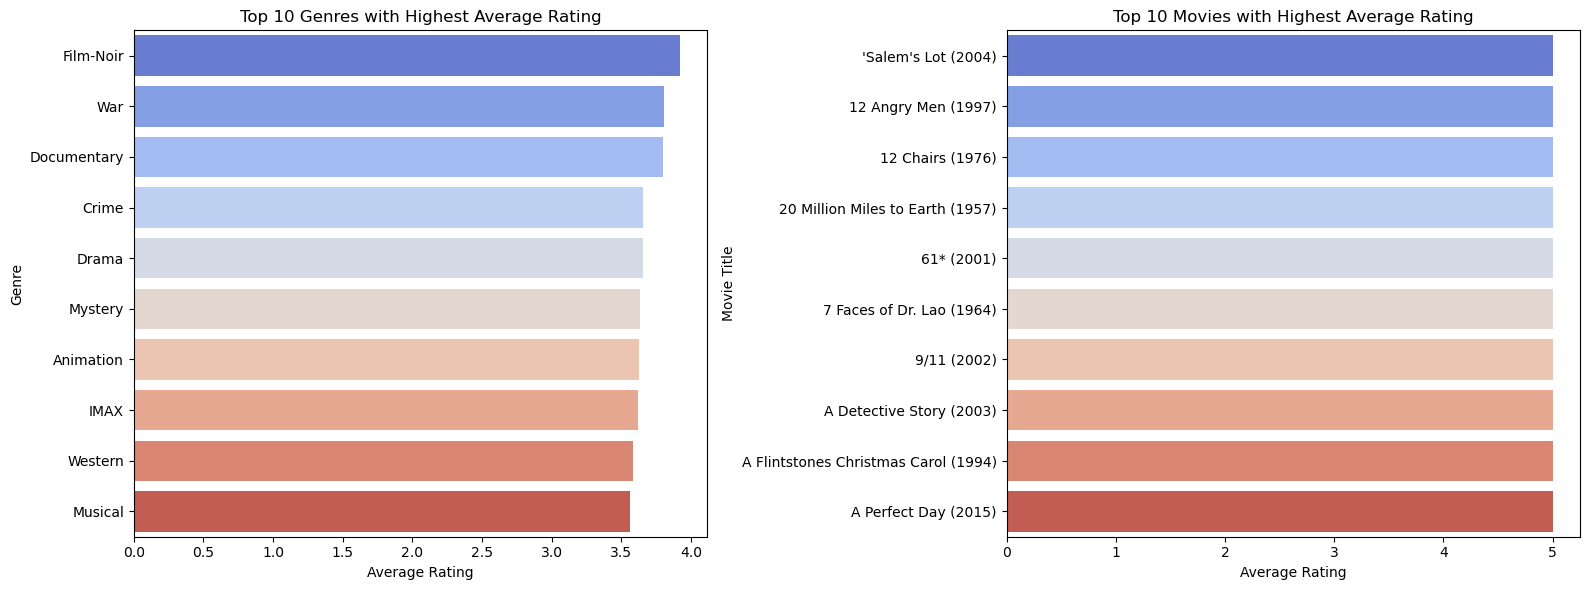

In [16]:
df_merged['genres'] = df_merged['genres'].str.split('|')
df_genres = df_merged.explode('genres')

avg_rating_by_genre = df_genres.groupby('genres')['rating'].mean().reset_index()
top10_genres = avg_rating_by_genre.nlargest(10, 'rating')

avg_rating_by_title = df_merged.groupby('title')['rating'].mean().reset_index()
top10_movies = avg_rating_by_title.nlargest(10, 'rating')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(
    x='rating',
    y='genres',
    data=top10_genres,
    palette='coolwarm',
    ax=axes[0]
)
axes[0].set_title("Top 10 Genres with Highest Average Rating")
axes[0].set_xlabel("Average Rating")
axes[0].set_ylabel("Genre")

sns.barplot(
    x='rating',
    y='title',
    data=top10_movies,
    palette='coolwarm',
    ax=axes[1]
)
axes[1].set_title("Top 10 Movies with Highest Average Rating")
axes[1].set_xlabel("Average Rating")
axes[1].set_ylabel("Movie Title")

plt.tight_layout()
plt.show()


### Top 10 Genre dan Film dengan Rata-Rata Rating Tertinggi
#### 🎯Tujuan:
Visualisasi ini menyoroti genre dan film dengan kualitas terbaik berdasarkan rata-rata rating tertinggi dari seluruh dataset.

---
#### 📊 Grafik Kiri – Top 10 Genre dengan Rata-Rata Rating Tertinggi
Menampilkan 10 genre teratas dengan rata-rata rating film tertinggi.

Genre teratas:
- Film-Noir ⭐ (paling tinggi)
- War
- Documentary
- Crime
- Drama

> 👉 Insight: Genre-genre seperti Film-Noir, War, dan Documentary meskipun mungkin tidak terlalu populer secara kuantitas, tetapi sangat diapresiasi dari segi kualitas oleh para penonton.
---
#### 🎥 Grafik Kanan – Top 10 Film dengan Rata-Rata Rating Tertinggi
Menampilkan 10 film dengan rating rata-rata paling tinggi dari seluruh dataset.

Semua film di atas memiliki rating hampir sempurna (mendekati 5.0).

- Contoh film:
- 'Salem's Lot (2004)
- 12 Angry Men (1997)
- 12 Chairs (1976)
- A Perfect Day (2015)

> 👉 Insight: Banyak dari film top ini adalah film klasik atau dokumenter, dan bukan blockbuster komersial. Hal ini mengindikasikan adanya penghargaan tinggi terhadap kualitas narasi, akting, dan pengaruh budaya.

---
#### 📌 Catatan Tambahan
| Genre/Film Tertinggi | Tipe Data | Rating |
| -------------------- | --------- | ------ |
| Film-Noir            | Genre     | ±3.9   |
| 'Salem's Lot (2004)  | Film      | 5.0    |

### 🎯 INSIGHT UTAMA DARI EDA
1. 🎬 Genre Tertentu Mendapat Rating Lebih Tinggi
   - Genre seperti Film-Noir, War, dan Documentary memiliki rata-rata rating tertinggi.
   - Meskipun bukan genre paling populer (dari jumlah review), genre-genre ini menunjukkan bahwa kualitas film di dalamnya lebih dihargai oleh penonton.
   - Ini menunjukkan adanya segmen pasar khusus yang sangat menghargai film dengan kualitas sinematik, naratif, atau nilai historis tinggi.

> 📌 Implikasi: Jika ingin fokus pada kualitas daripada kuantitas penonton, film bergenre ini patut dipertimbangkan.

---
2. 👥 Film Populer Tidak Selalu Mendapat Rating Tinggi
   - Beberapa genre seperti Action, Comedy, atau Sci-Fi, meskipun mungkin lebih populer dari segi jumlah review, memiliki rating rata-rata yang lebih rendah.
   - Genre-genre tersebut mungkin lebih bersifat menghibur, namun kurang dinilai tinggi dari sisi kualitas oleh reviewer.

> 📌 Implikasi: Populer ≠ Berkualitas (menurut penonton). Penting untuk menyeimbangkan tujuan komersial dan kualitas produksi.

---
3. 📈 Film-Film Top Punya Rating Hampir Sempurna
   - Film-film seperti 'Salem's Lot (2004) atau 12 Angry Men (1997) memiliki rating hampir sempurna (5.0).
   - Banyak dari film ini adalah film klasik, dokumenter, atau film dengan pendekatan naratif dan sinematik yang kuat.

> 📌 Implikasi: Film berkualitas tinggi yang kuat di aspek cerita dan akting bisa mempertahankan rating tinggi dalam jangka panjang.

---
4. 💬 Distribusi Review Tidak Merata antar Genre
   - Genre seperti Drama dan Comedy mendapatkan jumlah review yang sangat tinggi, namun tidak selalu menghasilkan rating tinggi.
   - Sebaliknya, genre seperti Film-Noir atau War memiliki jumlah review lebih sedikit tetapi rating sangat tinggi.

> 📌 Implikasi: Genre-genre yang lebih niche memiliki komunitas kecil tapi sangat loyal dan kritis.

---
5. 🔍 Multigenre Penting untuk Diperhitungkan
   - Karena kamu melakukan .str.split('|') dan .explode(), maka terlihat bahwa satu film bisa memiliki lebih dari satu genre.
   - Genre campuran dapat mempengaruhi persepsi rating (misalnya: Drama + War vs Drama + Romance).

> 📌 Implikasi: Saat mengklasifikasikan film atau merekomendasikan, pertimbangkan komposisi genre campuran, bukan hanya satu label utama.

---
6. 📊 Kesenjangan antara Jumlah Review dan Rating
   - Ada genre dengan review terbanyak (misalnya Drama atau Action) tapi rating tidak tinggi.
   - Ini bisa menunjukkan bahwa semakin banyak penonton, semakin besar variasi preferensi dan kritik (fenomena umum dalam film blockbuster).

> 📌 Implikasi: Film mainstream cenderung mendapatkan opini yang lebih beragam — strategi promosi & target audiens harus memperhitungkan hal ini.

# Modeling

## Content Based Filtering

### A. Data Preparation

In [17]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   userId        100836 non-null  int64  
 1   movieId       100836 non-null  int64  
 2   rating        100836 non-null  float64
 3   timestamp     100836 non-null  int64  
 4   title         100836 non-null  object 
 5   genres        100836 non-null  object 
 6   genres_split  100836 non-null  object 
 7   title_length  100836 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 6.2+ MB


#### 📄 Info Umum DataFrame
1. Tipe objek: pandas.core.frame.DataFrame
   - Ini berarti df_merged adalah objek DataFrame dari library pandas
2. RangeIndex: RangeIndex: 100836 entries, 0 to 100835
   - Menunjukkan ada 100.836 baris dimulai dari indeks 0 sampai 100835 (otomatis dari pandas).
3. Data columns (total 8 columns)
   - Ini berarti ada 8 kolom di dalam DataFrame ini.

---
#### 📋 Penjelasan Setiap Kolom

| No | Kolom          | Non-Null Count | Dtype     | Penjelasan                                                            |           |
| -- | -------------- | -------------- | --------- | --------------------------------------------------------------------- | --------- |
| 0  | `userId`       | 100836         | `int64`   | ID pengguna yang memberi rating                                       |           |
| 1  | `movieId`      | 100836         | `int64`   | ID film                                                               |           |
| 2  | `rating`       | 100836         | `float64` | Nilai rating yang diberikan pengguna (misalnya: 3.5, 4.0)             |           |
| 3  | `timestamp`    | 100836         | `int64`   | Waktu rating diberikan (dalam format Unix timestamp)                  |           |
| 4  | `title`        | 100836         | `object`  | Judul film                                                            |           |
| 5  | `genres`       | 100836         | `object`  | Genre film dalam format string (misalnya: "Drama Romance")            | 	       |
| 6  | `genres_split` | 100836         | `object`  | List genre hasil pemisahan string `genres` menggunakan \`.str.split('')\`|        |
| 7  | `title_length` | 100836         | `int64`   | Panjang judul film dalam jumlah karakter                              |           |


In [18]:
dataset_content = df_merged[['movieId', 'title', 'genres','rating', 'genres_split', 'title_length']].drop_duplicates('movieId').reset_index(drop=True)

dataset_content["movie_label"] = dataset_content["title"] + " (" + dataset_content["genres"].astype(str) + ")"

dataset_content["content_features"] = (
    dataset_content["genres_split"].apply(lambda x: " ".join(x)) + " " +
    dataset_content["title_length"].astype(str)
)

dataset_content.head()

,movieId,title,genres,rating,genres_split,title_length,movie_label,content_features
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",4.0,"[Adventure, Animation, Children, Comedy, Fantasy]",16,"Toy Story (1995) (['Adventure', 'Animation', '...",Adventure Animation Children Comedy Fantasy 16
1,3,Grumpier Old Men (1995),"[Comedy, Romance]",4.0,"[Comedy, Romance]",23,"Grumpier Old Men (1995) (['Comedy', 'Romance'])",Comedy Romance 23
2,6,Heat (1995),"[Action, Crime, Thriller]",4.0,"[Action, Crime, Thriller]",11,"Heat (1995) (['Action', 'Crime', 'Thriller'])",Action Crime Thriller 11
3,47,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",5.0,"[Mystery, Thriller]",27,"Seven (a.k.a. Se7en) (1995) (['Mystery', 'Thri...",Mystery Thriller 27
4,50,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",5.0,"[Crime, Mystery, Thriller]",26,"Usual Suspects, The (1995) (['Crime', 'Mystery...",Crime Mystery Thriller 26


#### 🎯 Tujuan Utama Kode
Mempersiapkan dataset konten film (untuk Content-Based Filtering) yang berisi fitur-fitur deskriptif dari film, seperti:
- title, genres, rating
- genres_split sebagai genre yang sudah dipisah-pisah
- title_length sebagai fitur numerik tambahan
- movie_label untuk pelabelan yang lebih informatif
- content_features sebagai gabungan genre dan panjang judul — siap untuk digunakan sebagai fitur konten (misal: TF-IDF, CountVectorizer, dll)

---
#### 🧩 Penjelasan Baris per Baris
1. Mengambil kolom penting

*Kode:*
**`dataset_content = df_merged[['movieId', 'title', 'genres','rating', 'genres_split', 'title_length']].drop_duplicates('movieId').reset_index(drop=True)`**
- Ambil kolom penting untuk analisis konten.
- drop_duplicates('movieId'): pastikan hanya satu film unik per baris.
- reset_index(drop=True): reset index setelah deduplikasi.

2. Membuat kolom `movie_label`

*Kode:* 
**`dataset_content["movie_label"] = dataset_content["title"] + " (" + dataset_content["genres"].astype(str) + ")"`**
- Buat kolom movie_label berisi gabungan title dan genres.
- Berguna untuk visualisasi, labeling, atau tampilan dropdown di UI.

3. Membuat Kolom `content_features`

*Kode:*
**`dataset_content["content_features"] = (
    dataset_content["genres_split"].apply(lambda x: " ".join(x)) + " " +
    dataset_content["title_length"].astype(str)
)`**

- Buat kolom content_features untuk representasi konten tiap film.
- Gabungan dari:
  - Genre (dijadikan satu string)
  - Panjang judul film

---
#### 📊 Isi dataset_content.head()
| movieId | title                   | genres                               | rating | genres\_split                     | title\_length | movie\_label                                         | content\_features               |
| ------- | ----------------------- | ------------------------------------ | ------ | --------------------------------- | ------------- | ---------------------------------------------------- | ------------------------------- |
| 1       | Toy Story (1995)        | \[Adventure, Animation, Children...] | 4.0    | \[Adventure, Animation, Children] | 16            | Toy Story (1995) (\[Adventure, Animation, Children]) | Adventure Animation Children 16 |
| 3       | Grumpier Old Men (1995) | \[Comedy, Romance]                   | 4.0    | \[Comedy, Romance]                | 23            | Grumpier Old Men (1995) (\[Comedy, Romance])         | Comedy Romance 23               |

---
#### 🎯 Insight & Tujuan
- Tujuan utama: Menyusun representasi konten tiap film agar bisa dihitung kemiripan antar film (content-based recommendation).
- Dengan content_features, kamu bisa pakai algoritma seperti cosine similarity untuk menemukan film dengan genre dan struktur judul yang mirip.



In [19]:
movie_titles = dataset_content["title"].tolist()

movie_labels = dataset_content["movie_label"].tolist()

content_features = dataset_content["content_features"].tolist()

print(f"Terdapat {len(movie_titles)} data judul film")
print(f"Terdapat {len(movie_labels)} data label film")
print(f"Terdapat {len(content_features)} data fitur konten (genre + panjang judul)")

Terdapat 9724 data judul film
Terdapat 9724 data label film
Terdapat 9724 data fitur konten (genre + panjang judul)


#### 🎯 Tujuan Kode
Kode ini bertujuan untuk:
- Mengambil list dari kolom-kolom penting dalam dataset_content.
- Memastikan bahwa setiap list memiliki jumlah data yang konsisten (yaitu 9724 film unik).
- Mengecek dan mencetak jumlah data pada tiap list — ini penting untuk validasi sebelum melanjutkan ke proses pembobotan fitur dan rekomendasi.

---
#### 🧱 Penjelasan Per Baris
1. Mengubah kolom `title` menjadi list

*Kode:*
`movie_titles = dataset_content["title"].tolist()`
- Mengubah kolom title (judul film) menjadi list Python biasa.
- Berguna untuk menampilkan daftar film atau mencari film berdasarkan judul.

2. Mengubah kolom `movie_label` menjadi list

*Kode:*
`movie_labels = dataset_content["movie_label"].tolist()`
- Mengubah kolom movie_label (gabungan title + genres) menjadi list.
- Sering dipakai untuk tampilan antarmuka (UI), dropdown pilihan, atau visualisasi.

3. Mengubah kolom `content_features` menjadi list

*Kode:*
`content_features = dataset_content["content_features"].tolist()`
- Mengubah kolom content_features menjadi list.
- Ini adalah fitur utama yang nanti akan diolah jadi representasi vektor untuk menghitung kemiripan antar film (misalnya dengan TF-IDF + cosine similarity).

4. Mengecek isi dalam dataset yang telah dikonversi menjadi list
- `print(f"Terdapat {len(movie_titles)} data judul film")`
- `print(f"Terdapat {len(movie_labels)} data label film")`
- `print(f"Terdapat {len(content_features)} data fitur konten (genre + panjang judul)")`

*Output:*
- Terdapat 9724 data judul film
- Terdapat 9724 data label film
- Terdapat 9724 data fitur konten (genre + panjang judul)

---
#### ✅ Kesimpulan & Validasi
1. Jumlah data film unik adalah 9724, artinya:
   - Deduplikasi movieId sudah berhasil.
   - Semua kolom penting (title, movie_label, content_features) sudah lengkap dan sejajar.

2. Siap untuk proses selanjutnya seperti:
   - TF-IDF Vectorization
   - Cosine Similarity
   - Rekomendasi konten berdasarkan kemiripan

In [20]:
content_based_data = pd.DataFrame({
    "title": dataset_content["title"],
    "movie_label": dataset_content["movie_label"],
    "content_features": dataset_content["content_features"]
})

content_based_data.head()

,title,movie_label,content_features
0,Toy Story (1995),"Toy Story (1995) (['Adventure', 'Animation', '...",Adventure Animation Children Comedy Fantasy 16
1,Grumpier Old Men (1995),"Grumpier Old Men (1995) (['Comedy', 'Romance'])",Comedy Romance 23
2,Heat (1995),"Heat (1995) (['Action', 'Crime', 'Thriller'])",Action Crime Thriller 11
3,Seven (a.k.a. Se7en) (1995),"Seven (a.k.a. Se7en) (1995) (['Mystery', 'Thri...",Mystery Thriller 27
4,"Usual Suspects, The (1995)","Usual Suspects, The (1995) (['Crime', 'Mystery...",Crime Mystery Thriller 26


#### 📦 Pembentukan content_based_data
Pada bagian ini, kita membentuk DataFrame baru bernama content_based_data yang akan digunakan sebagai dasar dalam sistem content-based recommendation.

---
#### 📑 Penjelasan Kolom:

| Kolom              | Deskripsi                                                                                                                                                              |
| ------------------ | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `title`            | Judul asli dari film (misalnya: *Toy Story (1995)*)                                                                                                                    |
| `movie_label`      | Gabungan antara judul dan genre film, digunakan untuk tampilan atau identifikasi film secara lengkap                                                                   |
| `content_features` | Gabungan dari **genre film** dan **panjang judul** yang telah disatukan dalam format string, dan digunakan sebagai fitur utama untuk mengukur **kemiripan antar film** |

---
#### ⏏️ Output (5 baris pertama):

| title                       | movie\_label                                                   | content\_features                              |
| --------------------------- | -------------------------------------------------------------- | ---------------------------------------------- |
| Toy Story (1995)            | Toy Story (1995) (\['Adventure', 'Animation', ...])            | Adventure Animation Children Comedy Fantasy 16 |
| Grumpier Old Men (1995)     | Grumpier Old Men (1995) (\['Comedy', 'Romance'])               | Comedy Romance 23                              |
| Heat (1995)                 | Heat (1995) (\['Action', 'Crime', 'Thriller'])                 | Action Crime Thriller 11                       |
| Seven (a.k.a. Se7en) (1995) | Seven (a.k.a. Se7en) (1995) (\['Mystery', 'Thriller'])         | Mystery Thriller 27                            |
| Usual Suspects, The (1995)  | Usual Suspects, The (1995) (\['Crime', 'Mystery', 'Thriller']) | Crime Mystery Thriller 26                      |

---
#### 🎯 Tujuan:
- Data ini nantinya akan diubah menjadi representasi vektor menggunakan TF-IDF (Term Frequency-Inverse Document Frequency) atau metode serupa, lalu digunakan untuk menghitung kemiripan antar film berdasarkan kontennya (genre + panjang judul).
- Dengan data ini, kita bisa membangun sistem rekomendasi yang menjawab:
> "Jika pengguna menyukai film X, film apa yang mirip dari segi kontennya?"

In [21]:
tfidf = TfidfVectorizer()

tfidf_matrix = tfidf.fit_transform(content_based_data["content_features"])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print("Cosine similarity matrix shape:", cosine_sim.shape)

Cosine similarity matrix shape: (9724, 9724)


#### 📐 Penerapan TF-IDF dan Cosine Similarity

1. 📚 Penjelasan
| Langkah                  | Penjelasan                                                                                                                                            |
| ------------------------ | ----------------------------------------------------------------------------------------------------------------------------------------------------- |
| `TfidfVectorizer()`      | Membuat objek untuk mengubah teks menjadi vektor numerik berbasis frekuensi dan kekhasan kata (TF-IDF).                                               |
| `fit_transform(...)`     | Menerapkan TF-IDF pada kolom `content_features`, menghasilkan matriks numerik berdimensi `(9724, fitur unik)`.                                        |
| `cosine_similarity(...)` | Menghitung kemiripan (cosine similarity) antar semua film berdasarkan vektor kontennya. Hasilnya adalah **matriks simetri** berukuran `(9724, 9724)`. |

---
2. 📏 Hasil:
`Cosine similarity matrix shape: (9724, 9724)`

Artinya:
- Kita memiliki 9724 film unik.
- Matriks ini menunjukkan tingkat kemiripan antar setiap pasang film.
- Nilai kemiripan berkisar antara 0 (tidak mirip) hingga 1 (sangat mirip).

In [22]:
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.37278331, 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.42283359, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.45475952, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

### 📊 Matriks Cosine Similarity

#### 🧩 Tujuan:
Matriks ini akan digunakan untuk membuat sistem rekomendasi, dengan cara memilih film yang memiliki nilai cosine similarity tertinggi terhadap film yang dipilih pengguna.

---
#### 🎯 Penjelasan:
- Matriks cosine similarity berukuran (9724, 9724).
- Setiap baris dan kolom merepresentasikan satu film.
- Nilai dalam matriks menunjukkan tingkat kemiripan antara dua film berdasarkan fitur kontennya (genre dan panjang judul).

---
#### 📌 Arti Nilai:
- Nilai 0.0 artinya tidak ada kemiripan antara dua film.
- Nilai 0.37, 0.42, dan 0.45 menunjukkan bahwa film di baris tersebut cukup mirip dengan film lain (nilai mendekati 1 berarti sangat mirip).
- Diagonal utama (yang tidak ditampilkan di sini) selalu bernilai 1.0 karena setiap film pasti 100% mirip dengan dirinya sendiri.

---
#### 📦 Contoh:
Jika cosine_sim[2, 8745] = 0.37278331, maka:
- Film ke-3 dan film ke-8746 memiliki kemiripan konten sebesar ~37.3%.
- Ini bisa jadi karena mereka memiliki genre yang sama atau panjang judul yang mirip.

In [23]:
tfidf_df = pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=content_based_data["movie_label"]
)

### 🎯Mengubah TF-IDF matrix menjadi DataFrame

#### 💡 Tujuan:
- Kode ini mengubah TF-IDF matrix yang sebelumnya berbentuk sparse (hemat memori) menjadi DataFrame pandas yang mudah dibaca dan dianalisis.
- Berguna untuk mengecek atau men-debug nilai TF-IDF tiap film secara manual.
- Bisa juga dipakai untuk visualisasi atau analisis fitur konten lebih lanjut (misalnya: genre mana yang paling banyak muncul atau paling kuat bobotnya di film tertentu).

---
#### 📚 Penjelasan:

| Komponen                                  | Penjelasan                                                                                                                                                                        |
| ----------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `tfidf_matrix`                            | Matriks hasil transformasi `TfidfVectorizer`, berisi bobot TF-IDF dari setiap fitur (genre + panjang judul) untuk tiap film.                                                      |
| `.todense()`                              | Mengubah sparse matrix menjadi dense (matriks penuh), agar bisa dibaca sebagai tabel.                                                                                             |
| `tfidf.get_feature_names_out()`           | Mengambil semua **fitur** (kata-kata unik dari `content_features`, misalnya: `Action`, `Comedy`, `Thriller`, `16`, dll) yang dipakai dalam TF-IDF. Ini akan jadi kolom DataFrame. |
| `index=content_based_data["movie_label"]` | Menjadikan **label film** sebagai indeks baris (row) dari DataFrame. Setiap baris mewakili satu film.                                                                             |

---

#### ✅ Kesimpulan:
tfidf_df akan menjadi DataFrame dengan:
- Rows: Nama-nama film (movie_label)
- Columns: Fitur konten unik (genre + panjang judul)
- Values: Nilai bobot TF-IDF (semakin tinggi → kata tersebut penting bagi film itu)

### B. Modeling and Result

In [24]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.08528593, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.08528593, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.31919541, 0.16952676,
        0.        ],
       ...,
       [0.        , 0.        , 0.31919541, ..., 1.        , 0.1922876 ,
        0.        ],
       [0.        , 0.        , 0.16952676, ..., 0.1922876 , 1.        ,
        0.5683273 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.5683273 ,
        1.        ]])

### 🚨 Consine Similarity 1
#### 📌 Apa Itu cosine_similarity?
`cosine_similarity` menghitung kemiripan antara dua vektor berdasarkan sudut di antara mereka, dengan nilai antara:
- 1.0 → dua item identik
- 0.0 → dua item tidak mirip sama sekali

Semakin tinggi nilainya, semakin mirip dua film tersebut dari segi konten (genre + panjang judul).

---
#### 🎯 Kegunaan Matriks Ini:
- Untuk sistem rekomendasi berbasis konten (Content-Based Filtering).
- Saat user menyukai film tertentu (misalnya film ke-0), kita bisa ambil film lain yang punya nilai similarity tertinggi terhadap film tersebut.

---
#### 🧮 Penjelasan Matriks Hasil:
Matriks cosine_sim adalah matriks simetris berukuran (9724, 9724), karena membandingkan setiap film dengan semua film lainnya, termasuk dirinya sendiri.

Misalnya:
- cosine_sim[0][0] = 1.0 → film ke-0 dibanding dengan dirinya sendiri (selalu 1).
- cosine_sim[0][1] = 0.08528593 → film ke-0 dan film ke-1 miripnya 8.5% secara konten.
- cosine_sim[2][973] = 0.31919541 → film ke-2 dan film ke-973 memiliki tingkat kemiripan 31.9%.
- Banyak nilai 0.0 karena genre atau panjang judul tidak sama → tidak mirip.

---
#### 📝 Kesimpulan:
Matriks cosine_sim berisi skor kemiripan antar film berdasarkan fitur konten (genre + panjang judul) yang telah diubah ke bentuk TF-IDF. Dan ini adalah dasar utama untuk membangun sistem rekomendasi film otomatis berbasis konten.

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix)

cosine_sim_df = pd.DataFrame(
    cosine_sim,
    index=content_based_data["movie_label"],
    columns=content_based_data["movie_label"]
)

print('Shape:', cosine_sim_df.shape)
cosine_sim_df.sample(5, axis=1).sample(15, axis=0)


Shape: (9724, 9724)


movie_label,"Dogville (2003) (['Drama', 'Mystery', 'Thriller'])","Zabriskie Point (1970) (['Drama', 'Romance'])",Twister (1990) (['Comedy']),Hush (2016) (['Thriller']),"Last Winter, The (2006) (['Horror'])"
movie_label,,,,,
"I Want to Live! (1958) (['Crime', 'Drama'])",0.091960,0.695241,0.000000,0.000000,0.0
"Think Like a Man Too (2014) (['Comedy', 'Romance'])",0.000000,0.263383,0.140380,0.000000,0.0
Eddie Izzard: Dress to Kill (1999) (['Comedy']),0.000000,0.000000,0.142016,0.000000,0.0
"Mesrine: Killer Instinct (L'instinct de mort) (2008) (['Action', 'Crime', 'Drama', 'Thriller'])",0.189318,0.074645,0.000000,0.145609,0.0
"How to Kill Your Neighbor's Dog (2000) (['Comedy', 'Drama'])",0.082707,0.102308,0.132198,0.000000,0.0
Particle Fever (2013) (['Documentary']),0.000000,0.000000,0.000000,0.000000,0.0
"Hotel Transylvania (2012) (['Animation', 'Children', 'Comedy'])",0.000000,0.000000,0.112676,0.000000,0.0
"Flightplan (2005) (['Action', 'Drama', 'Thriller'])",0.272884,0.107594,0.000000,0.209881,0.0
"Bus 174 (Ônibus 174) (2002) (['Crime', 'Documentary'])",0.000000,0.000000,0.000000,0.000000,0.0


### 🚨 Consine Similarity 2
#### 🎯 Tujuan:
-  untuk membuat sistem rekomendasi film.
-  Ketika user memilih 1 film, kita bisa:
  - Ambil baris dari cosine_sim_df
  - Urutkan film yang paling mirip
  - Rekomendasikan 5–10 film teratas

---
#### 📌 Penjelasan Setiap Bagian:
1. cosine_sim = cosine_similarity(tfidf_matrix)
- Menghitung kemiripan (cosine similarity) antar semua film berdasarkan content_features (genre + panjang judul).
- Output: array (9724, 9724) berisi nilai kemiripan antara semua kombinasi film.

2. cosine_sim_df = pd.DataFrame(...)
- Membuat DataFrame kemiripan antar film dengan:
    - Index = nama lengkap film (movie_label)
    - Kolom = juga nama lengkap film
- Hasilnya:
| movie\_label ↓ | Film A | Film B | Film C | ... |
| -------------- | ------ | ------ | ------ | --- |
| Film A         | 1.0    | 0.23   | 0.0    | ... |
| Film B         | 0.23   | 1.0    | 0.09   | ... |
| Film C         | 0.0    | 0.09   | 1.0    | ... |

3. cosine_sim_df.sample(5, axis=1).sample(15, axis=0)
- Menampilkan 5 kolom acak (film) dan 15 baris acak (film).
- Tujuannya untuk melihat cuplikan dari matriks kemiripan tanpa menampilkan semuanya.
- Output:
|movie\_label ↓       | Strictly Sexual | Firefox | Computer Wore Tennis Shoes | Rise of the Planet of the Apes | Zombie Strippers |
| -------------------- | --------------- | ------- | -------------------------- | ------------------------------ | ---------------- |
| Swimming with Sharks | 0.238           | 0.0     | 0.106                      | 0.075                          | 0.126            |
| Highway 61           | 0.154           | 0.0     | 0.126                      | 0.0                            | 0.151            |
| Days of Thunder      | 0.837           | 0.163   | 0.0                        | 0.214                          | 0.0              |

- Penjelasan:
  - Semua nilai berkisar antara 0 - 1:
  - 1.0 → identik (film dengan dirinya sendiri).
    > 0.5 → cukup mirip dari sisi genre dan panjang judul.
  - 0.0 → tidak ada kemiripan (tidak ada kata/fitur yang sama di TF-IDF-nya).

> Contoh: Days of Thunder punya similarity tinggi (0.837) dengan Strictly Sexual, berarti mereka punya genre atau panjang judul yang sangat mirip.



### C. Testing System Recommendation

In [26]:
def content_based_movie_recommendations(title, similarity_data=cosine_sim_df,
                                        items=content_based_data, k=10):
    match = items[items["title"].str.lower() == title.lower()]
    
    if match.empty:
        return f"Judul '{title}' tidak ditemukan dalam dataset."

    movie_label = match.iloc[0]["movie_label"]

    sim_scores = similarity_data[movie_label].sort_values(ascending=False)

    top_indices = sim_scores.iloc[1:k+1].index

    return items[items["movie_label"].isin(top_indices)].reset_index(drop=True)

### 🧠 Membuat Fungsi `content_based_movie_recommendations`

#### 🎯 Tujuan:
Memberikan rekomendasi film berdasarkan konten (genre + panjang judul) menggunakan cosine similarity.

---
#### 🔍 Penjelasan Setiap Baris:
1. 🟩 match = items[items["title"].str.lower() == title.lower()]
- Mencari judul film yang cocok dari parameter title.
- .str.lower() untuk menghindari perbedaan huruf kapital saat mencocokkan.

2. 🟥 if match.empty: return ...
Jika judul tidak ditemukan dalam data, maka fungsi akan mengembalikan pesan error.

3. 🟦 movie_label = match.iloc[0]["movie_label"]
- Mengambil label lengkap dari film yang ditemukan.
- Label ini digunakan untuk mengambil skor kemiripan dari cosine_sim_df.

4. 🟧 sim_scores = similarity_data[movie_label].sort_values(ascending=False)
- Mengambil seluruh nilai similarity dari film tersebut ke semua film lain.
- Diurutkan dari paling mirip ke paling tidak mirip (nilai cosine tertinggi ke rendah).

5. 🟨 top_indices = sim_scores.iloc[1:k+1].index
- Mengambil k film paling mirip.
- iloc[1:k+1] artinya mulai dari indeks ke-1 agar tidak mengambil film itu sendiri (indeks ke-0 = film itu sendiri, similarity-nya pasti 1.0).

6. 🟫 return items[items["movie_label"].isin(top_indices)].reset_index(drop=True)
- Mengembalikan k film yang paling mirip berdasarkan movie_label.
- reset_index(drop=True) agar indeks rapi saat ditampilkan.
---
#### 📚 Ringkasan Fungsi
| Komponen             | Fungsi                                                       |
| -------------------- | ------------------------------------------------------------ |
| **title**            | Judul film yang dimasukkan user                              |
| **similarity\_data** | Matriks cosine similarity antar film                         |
| **items**            | Dataset yang memuat info film dan fitur kontennya            |
| **k**                | Jumlah film rekomendasi yang ingin ditampilkan (default: 10) |


In [27]:
dataset_content[dataset_content.title.str.contains("Toy Story", case=False)]

,movieId,title,genres,rating,genres_split,title_length,movie_label,content_features
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",4.0,"[Adventure, Animation, Children, Comedy, Fantasy]",16,"Toy Story (1995) (['Adventure', 'Animation', '...",Adventure Animation Children Comedy Fantasy 16
735,3114,Toy Story 2 (1999),"[Adventure, Animation, Children, Comedy, Fantasy]",4.5,"[Adventure, Animation, Children, Comedy, Fantasy]",18,"Toy Story 2 (1999) (['Adventure', 'Animation',...",Adventure Animation Children Comedy Fantasy 18
1133,78499,Toy Story 3 (2010),"[Adventure, Animation, Children, Comedy, Fanta...",4.5,"[Adventure, Animation, Children, Comedy, Fanta...",18,"Toy Story 3 (2010) (['Adventure', 'Animation',...",Adventure Animation Children Comedy Fantasy IM...


### 🔎 Contoh Pencarian Dataset Content

#### 🎯 Tujuan:
Mencari semua film dalam dataset yang judulnya mengandung kata "Toy Story", baik huruf besar maupun kecil (case=False).

--- 
#### ✅ Insight:
| Aspek                | Penjelasan                                                                                                                                                                                                            |
| -------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Jumlah film**      | Ada **3 film** yang memiliki judul dengan "Toy Story", yaitu seri pertama, kedua, dan ketiga.                                                                                                                         |
| **Genre**            | Ketiganya memiliki **genre yang identik**, yaitu: `Adventure`, `Animation`, `Children`, `Comedy`, dan `Fantasy`.                                                                                                      |
| **Rating rata-rata** | Rating-nya relatif **tinggi dan konsisten**, dengan skor **4.0** hingga **4.5**, menunjukkan bahwa film ini sangat disukai pengguna.                                                                                  |
| **Panjang judul**    | `Toy Story (1995)` memiliki panjang **16 karakter**, sedangkan dua film lainnya **18 karakter**. Ini masuk dalam fitur `title_length`.                                                                                |
| **Content features** | Ketiganya memiliki `content_features` yang hampir identik (kombinasi genre + panjang judul), sehingga kemungkinan besar akan **saling merekomendasikan** jika digunakan pada sistem **content-based recommendation**. |


In [28]:
content_based_movie_recommendations("Toy Story (1995)")

,title,movie_label,content_features
0,Space Jam (1996),"Space Jam (1996) (['Adventure', 'Animation', '...",Adventure Animation Children Comedy Fantasy Sc...
1,Enchanted (2007),"Enchanted (2007) (['Adventure', 'Animation', '...",Adventure Animation Children Comedy Fantasy Mu...
2,Surf's Up (2007),"Surf's Up (2007) (['Animation', 'Children', 'C...",Animation Children Comedy 16
3,Life-Size (2000),"Life-Size (2000) (['Children', 'Comedy', 'Fant...",Children Comedy Fantasy 16
4,Anomalisa (2015),"Anomalisa (2015) (['Animation', 'Comedy', 'Fan...",Animation Comedy Fantasy 16
5,Peter Pan (2003),"Peter Pan (2003) (['Action', 'Adventure', 'Chi...",Action Adventure Children Fantasy 16
6,Ferdinand (2017),"Ferdinand (2017) (['Animation', 'Children', 'C...",Animation Children Comedy 16
7,Like Mike (2002),"Like Mike (2002) (['Children', 'Comedy', 'Fant...",Children Comedy Fantasy 16
8,"Wild, The (2006)","Wild, The (2006) (['Adventure', 'Animation', '...",Adventure Animation Children Comedy Fantasy 16
9,Pinocchio (2002),"Pinocchio (2002) (['Children', 'Comedy', 'Fant...",Children Comedy Fantasy 16


### Menjalankan Fungsi `content_based_movie_recommendations()`
#### 🎯 Tujuan:
Fungsi `content_based_movie_recommendations()` mencari film yang paling mirip secara konten (genre dan panjang judul) dengan film "Toy Story (1995)", berdasarkan cosine similarity dari representasi TF-IDF.

---
#### ✅ Insight:
- Sistem ini belum mempertimbangkan plot cerita, aktor, atau visual, hanya berdasarkan genre dan panjang judul (konten eksplisit).
- Kalau kamu ingin meningkatkan akurasi rekomendasi, bisa:
  - Menambahkan sinopsis/overview film
  - Menambahkan sutradara, pemeran, atau tahun rilis
  - Menggabungkan metode ini dengan collaborative filtering

## Collaborative-based Filtering

### 📚Apa itu Collaborative Filtering?
Collaborative Filtering (CF) merekomendasikan item berdasarkan interaksi pengguna lain.

`Pengguna A menyukai Film X dan Y. Jika Pengguna B menyukai X, maka B mungkin akan menyukai Y.`

---
### 📌 Dua Jenis Umum Collaborative Filtering:
1. User-Based Filtering
- Cari pengguna yang mirip (punya selera serupa).
- Rekomendasikan film yang disukai pengguna-pengguna mirip tersebut.

2. Item-Based Filtering
- Cari item (film) yang mirip berdasarkan pola rating pengguna.
- Rekomendasikan film yang mirip dengan film yang pernah disukai user.

### A. Data Preparation

In [29]:
dataset_filter = dataset_content[['movieId', 'title', 'genres_split', 'title_length', 'rating']].copy()

dataset_filter['genres_str'] = dataset_filter['genres_split'].apply(lambda x: " ".join(x))

dataset_filter['movie_label'] = dataset_filter['title'] + " (" + dataset_filter['genres_str'] + ")"

dataset_filter['content_features'] = dataset_filter['genres_str'] + " " + dataset_filter['title_length'].astype(str)

dataset_filter.head()


,movieId,title,genres_split,title_length,rating,genres_str,movie_label,content_features
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",16,4.0,Adventure Animation Children Comedy Fantasy,Toy Story (1995) (Adventure Animation Children...,Adventure Animation Children Comedy Fantasy 16
1,3,Grumpier Old Men (1995),"[Comedy, Romance]",23,4.0,Comedy Romance,Grumpier Old Men (1995) (Comedy Romance),Comedy Romance 23
2,6,Heat (1995),"[Action, Crime, Thriller]",11,4.0,Action Crime Thriller,Heat (1995) (Action Crime Thriller),Action Crime Thriller 11
3,47,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",27,5.0,Mystery Thriller,Seven (a.k.a. Se7en) (1995) (Mystery Thriller),Mystery Thriller 27
4,50,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",26,5.0,Crime Mystery Thriller,"Usual Suspects, The (1995) (Crime Mystery Thri...",Crime Mystery Thriller 26


### 🔖 Persiapan `content_features`
#### 🎯 Tujuan:
Mempersiapkan fitur konten (content_features) untuk sistem Content-Based Filtering berdasarkan:
- Genre film
- Panjang judul (title_length)

---
#### 📘 Penjelasan Baris per Baris:
1. *🧩 Kode:* `dataset_filter = dataset_content[['movieId', 'title', 'genres_split', 'title_length', 'rating']].copy()`

🎯 Membuat salinan dari dataset yang hanya berisi kolom yang relevan:
- `movieId`: ID film  
- `title`: Judul film  
- `genres_split`: Genre dalam bentuk list  
- `title_length`: Panjang karakter judul  
- `rating`: Rating rata-rata film

2. *🧩 Kode:* `dataset_filter['genres_str'] = dataset_filter['genres_split'].apply(lambda x: " ".join(x))`

🎯 Mengubah list genre (['Action', 'Thriller']) menjadi string 'Action Thriller'.
>Ini diperlukan karena TF-IDF vectorizer tidak bisa bekerja dengan list, tapi bisa dengan string teks.


3. *🧩 kode:* `dataset_filter['movie_label'] = dataset_filter['title'] + " (" + dataset_filter['genres_str'] + ")"`

🎯 Membuat label gabungan dari judul film dan genre-nya.  
Contoh:
>Toy Story (1995) (Adventure Animation Children Comedy Fantasy)

Ini berguna sebagai *identifier unik* di tabel-tabel hasil rekomendasi nanti.


4. *🧩 Kode:* `dataset_filter['content_features'] = dataset_filter['genres_str'] + " " + dataset_filter['title_length'].astype(str)`

🎯 Fitur konten utama = gabungan genre dan panjang judul.

Contoh:
>"Adventure Animation Children Comedy Fantasy 16"

Tujuannya: menggabungkan informasi tekstual (genre) dan fitur numerik (panjang judul) ke dalam satu string — supaya bisa digunakan dalam model TF-IDF + cosine similarity.

---
#### 🚨 Ini penting:
Karena `content_features` ini data yang sudah diubah menjadi *TF-IDF vector*, lalu dihitung kesamaannya (cosine similarity) dengan film lain. Semakin mirip genre dan ciri judulnya, semakin besar kemungkinan film itu direkomendasikan.

In [30]:
dataset_filter['film_id'] = dataset_filter['title'].apply(lambda x: x.split()[0][:3].upper()) + dataset_filter.index.astype(str)
dataset_filter.head()

,movieId,title,genres_split,title_length,rating,genres_str,movie_label,content_features,film_id
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",16,4.0,Adventure Animation Children Comedy Fantasy,Toy Story (1995) (Adventure Animation Children...,Adventure Animation Children Comedy Fantasy 16,TOY0
1,3,Grumpier Old Men (1995),"[Comedy, Romance]",23,4.0,Comedy Romance,Grumpier Old Men (1995) (Comedy Romance),Comedy Romance 23,GRU1
2,6,Heat (1995),"[Action, Crime, Thriller]",11,4.0,Action Crime Thriller,Heat (1995) (Action Crime Thriller),Action Crime Thriller 11,HEA2
3,47,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",27,5.0,Mystery Thriller,Seven (a.k.a. Se7en) (1995) (Mystery Thriller),Mystery Thriller 27,SEV3
4,50,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",26,5.0,Crime Mystery Thriller,"Usual Suspects, The (1995) (Crime Mystery Thri...",Crime Mystery Thriller 26,USU4


### ⏏️ Menambahkan Kolom `film_id`

#### 📌 Tujuan:

- Membuat identifier unik (film_id) untuk setiap film berdasarkan:
    - 3 huruf pertama dari kata pertama pada judul film, dan
    - index baris dataset.

- Agar film_id bisa digunakan untuk:
    - Identifier yang ringkas dan unik
    - Visualisasi data
    - Sistem rekomendasi
    - Debugging / filtering cepat

---
#### 🔍 Penjelasan Kode:
- `x.split()[0]`: Mengambil kata pertama dari judul film.
- `[:3].upper()`: Mengambil 3 huruf pertama dan mengubahnya menjadi huruf kapital.
- `dataset_filter.index.astype(str)`: Mengubah nilai index menjadi string.

>Contoh:
| Judul Film                  | Index | `film_id` |
| --------------------------- | ----- | --------- |
| Toy Story (1995)            | 0     | TOY0      |
| Grumpier Old Men (1995)     | 1     | GRU1      |
| Heat (1995)                 | 2     | HEA2      |
| Seven (a.k.a. Se7en) (1995) | 3     | SEV3      |
| Usual Suspects, The (1995)  | 4     | USU4      |

---


In [31]:
film_ids = dataset_filter["film_id"].unique().tolist()
print("List film_id:", film_ids)

film_to_film_encoded = {x: i for i, x in enumerate(film_ids)}
print("Encoded film_id:", film_to_film_encoded)

film_encoded_to_film = {i: x for i, x in enumerate(film_ids)}
print("Encoded angka ke film_id:", film_encoded_to_film)


List film_id: ['TOY0', 'GRU1', 'HEA2', 'SEV3', 'USU4', 'FRO5', 'BOT6', 'BRA7', 'ROB8', 'CAN9', 'DES10', 'BIL11', 'CLE12', 'DUM13', 'ED14', 'STA15', 'PUL16', 'STA17', 'TOM18', 'CLE19', 'FOR20', 'JUN21', 'MAS22', 'BLO23', 'DAZ24', 'FUG25', 'JUR26', 'MRS27', 'SCH28', 'SO29', 'THR30', 'TOM31', 'DAN32', 'BAT33', 'SIL34', 'PIN35', 'FAR36', 'MIS37', 'JAM38', 'SPA39', 'ROC40', 'TWI41', 'IND42', 'SHE43', 'WIZ44', 'CIT45', 'ADV46', 'GHO47', 'MR.48', 'ESC49', 'WIN50', 'THR51', 'SWO52', 'DUM53', 'PET54', 'BED55', 'ALI56', 'THA57', 'GHO58', 'SWI59', 'WIL60', 'MON61', 'RES62', 'PLA63', 'BAS64', 'E.T65', 'ABY66', 'MON67', 'STA68', 'PRI69', 'RAI70', 'CLO71', 'APO72', 'STA73', 'GOO74', 'ALI75', 'PSY76', 'BLU77', 'FUL78', 'HEN79', 'QUI80', 'TER81', 'DUC82', 'SHI83', 'GRO84', 'BAC85', 'HIG86', 'YOU87', 'FAN88', 'IND89', 'PIN90', 'NOS91', 'BAT92', 'SNE93', 'LAS94', 'MCH95', 'BES96', 'GRO97', 'AUS98', 'CON99', 'FAC100', 'MEN101', 'CON102', 'L.A103', 'KIS104', 'GAM105', 'I106', 'STA107', 'BIG108', 'WED109',

### 🎯 Encoding dan Decoding film_id
Langkah-langkah ini penting dalam sistem Collaborative Filtering karena algoritma machine learning biasanya membutuhkan input dalam bentuk angka, bukan string.

---
#### 🔎 Pemrosesan Kode
**1. 🔄 Mengambil film_id unik dalam bentuk list**

*🧩 Kode:* `film_ids = dataset_filter["film_id"].unique().tolist()`

📌 Tujuan: 
- Persiapan untuk proses encoding.
- Mengambil semua nilai film_id unik dari kolom.
- Mengubahnya menjadi list.

>🧾 Contoh hasil:
['TOY0', 'GRU1', 'HEA2', 'SEV3', 'USU4', ...]

**2. 🔢 Encoding: film_id → angka**

*🧩 Kode:* `film_to_film_encoded = {x: i for i, x in enumerate(film_ids)}`

📌 Tujuan:
- Mengubah setiap film_id menjadi angka menggunakan enumerate.
- Disimpan dalam bentuk dictionary.
- Format: {'TOY0': 0, 'GRU1': 1, ...}
- Agar film bisa direpresentasikan dalam format numerik saat diproses oleh model machine learning seperti matrix factorization.

**3. 🔁 Decoding: angka → film_id**

*🧩 Kode:* `film_encoded_to_film = {i: x for i, x in enumerate(film_ids)}`

📌 Tujuan:
- Setelah model memproses dan menghasilkan prediksi, kamu bisa mengubah angka kembali ke film_id untuk ditampilkan ke pengguna.
- Membuat mapping kebalikan dari sebelumnya.
- Format: {0: 'TOY0', 1: 'GRU1', ...}

---
#### ✅ Kesimpulan
| Langkah                | Tujuan         | Format                  |
| ---------------------- | -------------- | ----------------------- |
| `film_ids`             | List unik film | `['TOY0', 'GRU1', ...]` |
| `film_to_film_encoded` | Encoding       | `{'TOY0': 0, ...}`      |
| `film_encoded_to_film` | Decoding       | `{0: 'TOY0', ...}`      |


In [32]:
movie_labels = dataset_filter["movie_label"].unique().tolist()
print("List movie_label:", movie_labels)

movie_to_encoded = {x: i for i, x in enumerate(movie_labels)}
print("Encoded film_id:", movie_to_encoded)

encoded_to_movie = {i: x for i, x in enumerate(movie_labels)}
print("Encoded angka ke film_id:", encoded_to_movie)

List movie_label: ['Toy Story (1995) (Adventure Animation Children Comedy Fantasy)', 'Grumpier Old Men (1995) (Comedy Romance)', 'Heat (1995) (Action Crime Thriller)', 'Seven (a.k.a. Se7en) (1995) (Mystery Thriller)', 'Usual Suspects, The (1995) (Crime Mystery Thriller)', 'From Dusk Till Dawn (1996) (Action Comedy Horror Thriller)', 'Bottle Rocket (1996) (Adventure Comedy Crime Romance)', 'Braveheart (1995) (Action Drama War)', 'Rob Roy (1995) (Action Drama Romance War)', 'Canadian Bacon (1995) (Comedy War)', 'Desperado (1995) (Action Romance Western)', 'Billy Madison (1995) (Comedy)', 'Clerks (1994) (Comedy)', 'Dumb & Dumber (Dumb and Dumber) (1994) (Adventure Comedy)', 'Ed Wood (1994) (Comedy Drama)', 'Star Wars: Episode IV - A New Hope (1977) (Action Adventure Sci-Fi)', 'Pulp Fiction (1994) (Comedy Crime Drama Thriller)', 'Stargate (1994) (Action Adventure Sci-Fi)', 'Tommy Boy (1995) (Comedy)', 'Clear and Present Danger (1994) (Action Crime Drama Thriller)', 'Forrest Gump (1994) (Co

### 🎬 Encoding dan Decoding movie_label
Langkah ini penting dalam sistem rekomendasi berbasis collaborative filtering, karena model membutuhkan data dalam bentuk angka, bukan teks.

---
#### 📈 Tahapan Pemrosesan:
**1. 🔄 Mengubah movie_label menjadi list unik**

*🧩 Kode:* `movie_labels = dataset_filter["movie_label"].unique().tolist()`

- Tujuan:
    - Mengambil semua nilai unik dari kolom movie_label.
    - Disimpan sebagai list agar bisa di-enumerate.

- Contoh isi movie_label:
>"Toy Story (1995) (Adventure Animation Children Comedy Fantasy)"

**2. 🔢 Encoding: movie_label → angka**

*🧩 Kode:* `movie_to_encoded = {x: i for i, x in enumerate(movie_labels)}`


- Tujuan:
  - representasi film dalam bentuk angka supaya bisa diproses model.
  - Mengubah setiap label film menjadi angka (index).

- Format:
> {
  'Toy Story (1995) (...)': 0,
  'Grumpier Old Men (1995) (...)': 1,
  ...
}


**3. 🔁 Decoding: angka → movie_label**

*🧩 Kode:* `encoded_to_movie = {i: x for i, x in enumerate(movie_labels)}`

- Tujuan:
    - agar hasil prediksi berupa angka bisa dikembalikan ke label film asli.
    - Membalik proses encoding di atas.

- Format:
>{
  0: 'Toy Story (1995) (...)',
  1: 'Grumpier Old Men (1995) (...)',
  ...
}

---
#### 🔎 Kesimpulan

| Langkah            | Tujuan    | Hasil                                    |
| ------------------ | --------- | ---------------------------------------- |
| `movie_labels`     | List unik | `['Toy Story (...)', 'Heat (...)', ...]` |
| `movie_to_encoded` | Encoding  | `{'Toy Story (...)': 0, ...}`            |
| `encoded_to_movie` | Decoding  | `{0: 'Toy Story (...)', ...}`            |

> 📝 Catatan: Encoding ini nantinya akan berguna saat akan membangun model matrix factorization atau neural collaborative filtering, agar input/output model tetap konsisten dalam bentuk numerik.

In [33]:
dataset_filter["track"] = dataset_filter["film_id"].map(film_to_film_encoded)

dataset_filter["name"] = dataset_filter["movie_label"].map(movie_to_encoded)

### 🔗 Menambahkan Kolom `track` dan `name` ke Dataset
Tujuan dari langkah ini adalah menambahkan representasi numerik dari film_id dan movie_label ke dalam dataframe dataset_filter, yang akan berguna dalam proses training model berbasis Collaborative Filtering.

---
#### 📑 Tahapan Pemrosesan
**1. 📌 track → Hasil Encoding dari film_id**

*🧩 Kode:* `dataset_filter["track"] = dataset_filter["film_id"].map(film_to_film_encoded)`

- Tujuan:
  - Menjadikan setiap film memiliki ID numerik unik untuk pemrosesan machine learning.
  - Kolom film_id (contoh: TOY0, HEA2, dll.) dipetakan ke angka menggunakan dictionary film_to_film_encoded.
  - Hasilnya dimasukkan ke kolom baru bernama track.

**2. 📌 name → Hasil Encoding dari movie_label**

*🧩 Kode:* `dataset_filter["name"] = dataset_filter["movie_label"].map(movie_to_encoded)`

- Tujuan:
  - Menghubungkan representasi deskriptif film ke representasi numerik (label yang akan digunakan untuk pelatihan model rekomendasi).
  - Kolom movie_label (berisi judul film + genre) dipetakan ke angka berdasarkan dictionary movie_to_encoded.
  - Disimpan dalam kolom baru name.

---
#### 🎯 Hasil Tahapan:
| title            | film\_id | movie\_label                    | track | name |
| ---------------- | -------- | ------------------------------- | ----- | ---- |
| Toy Story (1995) | TOY0     | Toy Story (1995) (Adventure...) | 0     | 0    |
| Heat (1995)      | HEA2     | Heat (1995) (Action Crime...)   | 2     | 2    |
> 🔄 Kolom track dan name mungkin tampak mirip, tapi dibuat dari field yang berbeda: film_id dan movie_label.

In [34]:
num_track = len(film_to_film_encoded)
print(num_track)

num_name = len(encoded_to_movie)
print(num_name)

min_popularity = min(dataset_filter["rating"])

max_popularity = max(dataset_filter["rating"])

print("Number of Track ID: {}, Number of Track Name: {}, Min popularity: {}, Max popularity: {}".format(
    num_track, num_name, min_popularity, max_popularity
))

9724
9724
Number of Track ID: 9724, Number of Track Name: 9724, Min popularity: 0.5, Max popularity: 5.0


### 📊 Statistik Dasar Dataset Film
Kode ini bertujuan untuk menampilkan jumlah item unik dan rentang rating pada dataset film yang telah diencode.

---
#### 📑 Tahapan Pemrosesan
1. **🔢 Jumlah Unik Film**

`rack = len(film_to_film_encoded)`

`num_name = len(encoded_to_movie)`

- Tujuan:
  - `num_track` menghitung jumlah `film_id ` unik yang telah di-encode ke bentuk angka.
  - `num_name` menghitung jumlah `movie_label` unik (judul + genre) yang telah di-encode.

- Hasil:
    - 🎞️ 9724 film unik berdasarkan ID (film_id)
    - 🎬 9724 judul film unik berdasarkan deskripsi (movie_label)

2. **⭐ Rentang Popularitas (Rating)**

`min_popularity = min(dataset_filter["rating"])`

`max_popularity = max(dataset_filter["rating"])`

- Insight:
  - `min_popularity`: nilai rating terendah dalam dataset (popularitas minimal).
  - `max_popularity`: nilai rating tertinggi dalam dataset (popularitas maksimal).

- Hasil:
    - 📉 Rating terendah: 0.5
    - 📈 Rating tertinggi: 5.0
---
#### 🔍 Kesimpulan: 
**Dataset ini terdiri dari 9724 film unik, dengan rentang rating dari 0.5 hingga 5.0. Ini penting untuk skala normalisasi atau thresholding saat melatih model rekomendasi.**


In [35]:
collaborative_based = dataset_filter[["track", "name", "rating"]].sample(frac = 1, random_state = 42)
collaborative_based

,track,name,rating
1145,1145,1145,4.0
8505,8505,8505,5.0
3903,3903,3903,4.5
1608,1608,1608,4.0
9141,9141,9141,2.0
...,...,...,...
5734,5734,5734,2.0
5191,5191,5191,0.5
5390,5390,5390,4.0
860,860,860,4.0


### 🎲 Menyiapkan Data untuk Collaborative Filtering
Pada tahap ini, kita menyiapkan dataset akhir yang akan digunakan untuk Collaborative Filtering berdasarkan atribut:
- `track`: ID numerik dari film (film_id)
- `name`: Label film (movie_label)
- `rating`: Rating sebagai representasi preferensi pengguna

#### 📦 Tahap Pemrosesan:
1. **Utama:**
- *🧩 Kode:* `collaborative_based = dataset_filter[["track", "name", "rating"]].sample(frac=1, random_state=42)`

2. **Penjelasan:**
- *🧩 Kode:* `dataset_filter[["track", "name", "rating"]]`
> Mengambil hanya kolom yang relevan untuk model rekomendasi berbasis kolaboratif.

- *🧩 Kode:* `.sample(frac=1, random_state=42)`
> Mengacak seluruh baris (100% data karena frac=1), sambil menjaga konsistensi pengacakan dengan random_state=42.

---
#### 💡 Catatan:
**Track dan Name memiliki nilai yang sama karena sebelumnya telah dibuat dengan indeks yang identik (film_id dan movie_label dipetakan ke angka berdasarkan urutan).**

In [36]:
x = collaborative_based[["track", "name"]].values
y = collaborative_based["rating"].apply(lambda x: (x - min_popularity) / (max_popularity - min_popularity)).values

train_indices = int(0.8 * collaborative_based.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print("x example:", x[:3])
print("y example:", y[:3])
print("Train size:", x_train.shape, y_train.shape)
print("Val size:", x_val.shape, y_val.shape)


x example: [[1145 1145]
 [8505 8505]
 [3903 3903]]
y example: [0.77777778 1.         0.88888889]
Train size: (7779, 2) (7779,)
Val size: (1945, 2) (1945,)


### 📊 Menyiapkan Data Training dan Validasi untuk Collaborative Filtering
Pada bagian ini, data diformat agar bisa digunakan untuk melatih model machine learning, khususnya model rekomendasi berbasis Collaborative Filtering Neural Network.

---
#### 📑 Tahapan Pemrosesan:

1. *🧩 Kode:* `x = collaborative_based[["track", "name"]].values`
- Mengambil kolom track (film ID numerik) dan name (movie_label numerik) sebagai fitur input (x).
- Hasil akhir:
  > array 2D [ [track, name], ... ] berisi pasangan fitur (anggap seperti user_id dan item_id, meskipun di sini keduanya adalah film).

2. *🧩 Kode:* `y = collaborative_based["rating"].apply(lambda x: (x - min_popularity) / (max_popularity - min_popularity)).values`

- Melakukan normalisasi rating ke skala 0–1 menggunakan Min-Max Scaling.
> Ini penting untuk stabilitas pelatihan model neural network.


3. 🧪 Membagi Data: Train dan Validation

- *🧩 Kode:* `train_indices = int(0.8 * collaborative_based.shape[0])`
  - Menghitung jumlah data untuk training (80% dari total data).

-  *🧩 Kode:*


`x_train, x_val, y_train, y_val = (`


   `x[:train_indices],`


   `x[train_indices:],`


   `y[:train_indices],`


   `y[train_indices:]`

   
`)`

   - Membagi x dan y ke dalam data training (80%) dan validasi (20%).

---
#### 📌 Catatan
**Data sekarang sudah siap digunakan untuk melatih model rekomendasi berbasis neural network seperti Embedding + Dense layers.**

### B. Modeling

In [37]:
class RecommenderNet(tf.keras.Model):

    def __init__(self, num_track, num_name, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_track = num_track
        self.num_name = num_name
        self.embedding_size = embedding_size

        self.track_embedding = layers.Embedding(
            num_track,
            embedding_size,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-4)
        )

        self.name_embedding = layers.Embedding(
            num_name,
            embedding_size,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-4)
        )

        self.name_bias = layers.Embedding(num_name, 1)
        self.track_bias = layers.Embedding(num_track, 1)
        self.dropout = layers.Dropout(0.3)
        
    def call(self, inputs):
        track_vector = self.track_embedding(inputs[:,0])
        track_bias = self.track_bias(inputs[:, 0]) 
        name_vector = self.name_embedding(inputs[:, 1])
        name_bias = self.name_bias(inputs[:, 1])

        dot_track_name = tf.reduce_sum(track_vector * name_vector, axis=1, keepdims=True)

        x = dot_track_name + track_bias + name_bias
        x = self.dropout(x)
        
        return tf.nn.sigmoid(tf.keras.layers.Flatten()(x))

### 💡 Model RecommenderNet: Collaborative Filtering dengan Neural Network
Model ini merupakan Neural Collaborative Filtering berbasis Embedding Layer. 
- 🎯 Tujuannya:
   - memprediksi skor rating (yang telah dinormalisasi) dari pasangan track dan name (dalam konteks ini keduanya adalah film).
---
#### 🔗 Alur Kode:
**1. 🧱 Struktur Class RecommenderNet**
- *🧩 Kode 1:*

  `class RecommenderNet(tf.keras.Model)`
   > - Inisialisasi custom model menggunakan tf.keras.Model sebagai superclass.
   > - Dibuat untuk mempelajari representasi (embedding) dan hubungan antara track dan name.

**2. 🔧 __init__() — Inisialisasi Layer**
- *🧩 Kode 1:*

  `self.track_embedding = layers.Embedding(...)`

  `self.name_embedding = layers.Embedding(...)`
  > - Layer Embedding untuk track dan name. Masing-masing merepresentasikan ID film ke dalam vektor berdimensi embedding_size.
    
- *🧩 Kode 2:*

    `self.name_bias = layers.Embedding(num_name, 1)`

    `self.track_bias = layers.Embedding(num_track, 1)`
  > - Bias tambahan per track dan name (mirip dengan bias per user dan item dalam matrix factorization).

- *🧩 Kode 3:*
    `self.dropout = layers.Dropout(0.3)`

  > - Menonaktifkan 30% neuron selama training (mengurangi overfitting)
  
**3. 🔁 call() — Proses Forward Pass**

- *🧩 Kode 1:*

    `track_vector = self.track_embedding(inputs[:,0])`

    `track_bias = self.track_bias(inputs[:, 0])`
  > - Mengambil vektor embedding dan bias untuk track.

- *🧩 Kode 2:*

    `name_vector = self.name_embedding(inputs[:, 1])`

    `name_bias = self.name_bias(inputs[:, 1])`
  > - Mengambil vektor embedding dan bias untuk name.

- *🧩 Kode 3:*

    `dot_track_name = tf.reduce_sum(track_vector * name_vector, axis=1, keepdims=True)`

    `Operasi utama: menghitung dot product antara embedding track dan name.`

  > - Dot product merepresentasikan seberapa besar kecocokan antara dua entitas (semakin besar, semakin cocok).

- *🧩 Kode 4:*

    `x = dot_track_name + track_bias + name_bias`
  > - Menambahkan bias individual ke hasil dot product.
- *🧩 Kode 5:*
    `x = self.dropout(x)`
  > - Menambahkan dropout setelah kombinasi
- *🧩 Kode 6:*
    `return tf.nn.sigmoid(tf.keras.layers.Flatten()(x))`
  > - Hasil akhir dilalui fungsi aktivasi sigmoid, sehingga output berada di antara 0–1.
  > - Flatten() memastikan hasilnya berupa vektor 1 dimensi.

---
#### 🧠 Tujuan Utama
Model ini akan belajar:
- Vektor embedding track dan name yang optimal.
- Bias dari masing-masing track dan name.
- Pola interaksi antara mereka yang menghasilkan prediksi skor mirip rating.

In [38]:
model = RecommenderNet(num_track, num_name, embedding_size=50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

### 🔧 Kompilasi Model RecommenderNet
Setelah membuat arsitektur RecommenderNet, langkah selanjutnya adalah meng-compile model agar siap untuk dilatih.

--- 
#### Tahapan Modelling
**1. 📦 Membuat Instance Model**
- *🧩 Kode 1:*

    `model = RecommenderNet(num_track, num_name, embedding_size=20)`
    > - Membuat objek dari class RecommenderNet.

**2. ⚙️ Compile Model**
- *🧩 Kode 5:*

`model.compile(`

`    loss = tf.keras.losses.BinaryCrossentropy(),`    

`    optimizer = keras.optimizers.Adam(learning_rate = 0.001),`

`    metrics = [tf.keras.metrics.RootMeanSquaredError()]`

`)`

- ✅ Penjelasan:
    1. loss = BinaryCrossentropy()
       - Meski rating adalah nilai numerik, model memprediksi skor dalam skala [0,1] (karena sigmoid di output).
       - Maka, binary crossentropy digunakan untuk mengukur seberapa jauh prediksi dari target.
       - Ini bekerja dengan baik saat target (rating) telah dinormalisasi.
    2. optimizer = Adam(learning_rate = 0.001)
       - Adam adalah optimisasi populer berbasis adaptasi learning rate, cepat konvergen.
       - Learning rate 0.001 adalah nilai standar yang sering bekerja baik.
       - metrics = [RootMeanSquaredError()].
       - Untuk mengevaluasi model dengan metrik RMSE (Root Mean Squared Error), karena ini umum dipakai dalam sistem rekomendasi.
---
#### 🎯 Hasil Akhir
**Model siap untuk dilatih menggunakan .fit() dengan data training (x_train, y_train) dan validasi (x_val, y_val).**

In [39]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 50,
    validation_data = (x_val, y_val)
)

Epoch 1/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6968 - root_mean_squared_error: 0.2743 - val_loss: 0.6931 - val_root_mean_squared_error: 0.2724
Epoch 2/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6886 - root_mean_squared_error: 0.2694 - val_loss: 0.6931 - val_root_mean_squared_error: 0.2724
Epoch 3/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6829 - root_mean_squared_error: 0.2642 - val_loss: 0.6931 - val_root_mean_squared_error: 0.2724
Epoch 4/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6767 - root_mean_squared_error: 0.2590 - val_loss: 0.6931 - val_root_mean_squared_error: 0.2724
Epoch 5/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6709 - root_mean_squared_error: 0.2536 - val_loss: 0.6931 - val_root_mean_squared_error: 0.2724
Epoch 6/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6654 - root_mean_squared_error: 0.2482 - val_loss: 0.6931 - val_root_mean_squared_error: 0.2724
Epoch 7/50
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

### 🚀 Melatih Model
#### 📝 Penjelasan Parameter:
| Parameter                        | Fungsi                                                                                                          |
| -------------------------------- | --------------------------------------------------------------------------------------------------------------- |
| `x_train`                        | Input fitur training, berupa pasangan `track` dan `name` yang telah di-*encode*.                                |
| `y_train`                        | Label/target training, berupa **rating yang telah dinormalisasi ke skala 0–1**.                                 |
| `batch_size=32`                  | Jumlah sampel yang diproses sebelum parameter model diupdate. Ukuran kecil seperti 32 bagus untuk generalisasi. |
| `epochs=50`                      | Model akan melalui seluruh dataset training sebanyak **50 kali**.                                               |
| `validation_data=(x_val, y_val)` | Dataset validasi untuk memantau performa model di data yang tidak dilatih, pada akhir setiap epoch.             |

---
#### 📦 Apa yang Dihasilkan?
- Variabel history menyimpan log proses training, termasuk:
  - Nilai loss dan RMSE untuk training dan validasi setiap epoch.
  - Data ini bisa digunakan untuk visualisasi kurva learning.



### C. Testing System Recommendation

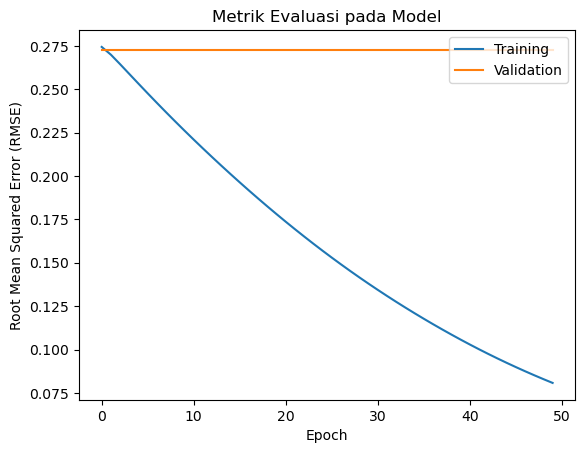

In [40]:
plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])

plt.title("Metrik Evaluasi pada Model")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc = "upper right")

plt.show()

### 📌 Penjelasan Grafik

**1. 📉 RMSE Training Menurun Konsisten**
- Grafik menunjukkan bahwa RMSE pada data training terus menurun secara stabil seiring bertambahnya epoch. Ini artinya:
  - Model berhasil belajar dari data.
  - Tidak ada masalah besar seperti overfitting ekstrim (kalau ada, RMSE training akan menurun tajam tapi validation malah naik).
  - Stabilitas Model

**2. 🚀 RMSE pada data validasi tampak stabil**
- Model tidak mengalami perubahan drastis atau ketidakstabilan saat pelatihan.
- Bisa menjadi indikasi bahwa model cukup resisten terhadap noise, atau memang validasi datanya sudah cukup homogen.
- Cocok untuk Use Case Ringan
    > Karena ini adalah eksperimen ML sederhana, model ini sudah cukup representatif untuk digunakan dalam pembelajaran, prototipe awal, atau aplikasi dengan lingkup terbatas seperti:
    - Sistem rekomendasi lokal
    - Uji coba model embedding
    - Pembelajaran konsep rekomendasi

In [41]:
def recommend_movies_based_on_title(movie_label, top_n=10):
    if movie_label not in movie_to_encoded:
        print(f"Film dengan label '{movie_label}' tidak ditemukan.")
        return

    encoded_movie_label = movie_to_encoded[movie_label]

    all_film_ids = list(film_to_film_encoded.values())

    movie_label_array = np.array([[encoded_movie_label]] * len(all_film_ids))
    film_id_array = np.array(all_film_ids).reshape(-1, 1)
    input_array = np.hstack((film_id_array, movie_label_array))

    predicted_scores = model.predict(input_array).flatten()

    top_indices = predicted_scores.argsort()[-top_n:][::-1]
    recommended_film_encoded_ids = [all_film_ids[i] for i in top_indices]

    recommended_film_ids = [film_encoded_to_film.get(encoded_id) for encoded_id in recommended_film_encoded_ids]

    print(f"\nRekomendasi film berdasarkan: '{movie_label}'")
    for film_id in recommended_film_ids:
        info = dataset_filter[dataset_filter["film_id"] == film_id]
        if not info.empty:
            title = info["title"].values[0]
            genres = info["genres_str"].values[0]
            rating = info["rating"].values[0]
            print(f"🎬 {title} | Genre: {genres} | Rating: {rating}")
        else:
            print(f"- Film ID '{film_id}' tidak ditemukan di dataset.")


### 💡 Fungsi dan Tujuan
Fungsi ini bertujuan untuk memberikan rekomendasi film berdasarkan film input tertentu (judulnya), dengan memanfaatkan model pembelajaran mesin yang sudah dilatih.

---
#### ✅ Keunggulan:
- Sudah menangani pengecekan input tidak valid.
- Bisa memberikan rekomendasi berdasarkan pembelajaran model.
- Output sudah ramah pengguna: menampilkan genre dan rating.

In [42]:
dataset_filter[dataset_filter["title"].eq("Toy Story (1995)")]

,movieId,title,genres_split,title_length,rating,genres_str,movie_label,content_features,film_id,track,name
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",16,4.0,Adventure Animation Children Comedy Fantasy,Toy Story (1995) (Adventure Animation Children...,Adventure Animation Children Comedy Fantasy 16,TOY0,0,0


### 🗳️ Penyaringan Baris
#### 🔍 Penjelasan:
*1. 🧩Kode:* `dataset_filter["title"].eq("Toy Story (1995)")`:

- Mengecek setiap baris apakah kolom "title" sama persis dengan "Toy Story (1995)". Hasilnya adalah array boolean (True jika cocok, False jika tidak).

*2. 🧩Kode:* `dataset_filter[...]`:
- Menggunakan hasil pengecekan tadi untuk menyaring baris di DataFrame.
---
#### 🧾 Tujuan:
- Untuk melihat informasi detail tentang film "Toy Story (1995)" di dalam dataset, seperti:
  - ID film
  - Genre
  - Rating
  - Kolom lain yang tersedia

In [43]:
recommend_movies_based_on_title("Toy Story (1995) (Adventure Animation Children Comedy Fantasy)")

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step

Rekomendasi film berdasarkan: 'Toy Story (1995) (Adventure Animation Children Comedy Fantasy)'
🎬 Paris Is Burning (1990) | Genre: Documentary | Rating: 5.0
🎬 Big Sleep, The (1946) | Genre: Crime Film-Noir Mystery | Rating: 5.0
🎬 La Cérémonie (1995) | Genre: Crime Drama Mystery Thriller | Rating: 5.0
🎬 L.I.E. (2001) | Genre: Drama | Rating: 5.0
🎬 Inside Job (2010) | Genre: Documentary | Rating: 5.0
🎬 Little Princess, A (1995) | Genre: Children Drama | Rating: 5.0
🎬 Tyler Perry's I Can Do Bad All by Myself (2009) | Genre: Comedy Drama | Rating: 5.0
🎬 Bambi (1942) | Genre: Animation Children Drama | Rating: 5.0
🎬 Jiro Dreams of Sushi (2011) | Genre: Documentary | Rating: 5.0
🎬 Denise Calls Up (1995) | Genre: Comedy | Rating: 5.0


### ⚙️ Menjalankan Fungsi
#### ✅ Penjelasan Langkah yang Terjadi:
- Pencocokan Label:
    > Fungsi akan mencocokkan "Toy Story (1995) (Adventure Animation Children Comedy Fantasy)" ke dalam dictionary movie_to_encoded.

- Input ke Model:
    > Akan dibuat array kombinasi dari semua film_id dengan movie_label dari "Toy Story", untuk memprediksi seberapa besar kemungkinan pengguna menyukai film lain jika ia menyukai Toy Story.

- Prediksi:
    > Model memberikan prediksi skor (antara 0–1) menggunakan model.predict() untuk semua kombinasi tersebut.

- Pemilihan Top-N:
    > Mengambil top N film (default top_n=10) dengan skor prediksi tertinggi.

- Output:
    > Menampilkan daftar film rekomendasi dengan:

- 🎬 Judul film:
    - Genre
    - Rating

# Referensi
[[1]]https://j-ptiik.ub.ac.id/index.php/j-ptiik/article/download/9163/4159/64730

[[2]]https://sensasi.upnjatim.ac.id/index.php/sensasi/article/view/83

[3] Dicoding. Diakses pada 12 Juni 2025 dari https://www.dicoding.com/academies/319-machine-learning-terapan

[4] Kaggle. Diakses pada 16 Juni 2025 dari https://www.kaggle.com/datasets/abhikjha/movielens-100k